# Figure 1 (in vivo clones)

# Loading the data

Here we load all the packages that we need, and import the data (loom files, from the preprocessing notebook).

## Loading packages

In [1]:
#Import packages.  Put plots "inline" in the notebook.  

import numpy as np  # For numerical computations.
import pandas as pd  # Pandas for data analysis.
from IPython.display import display # Pretty display of data frames.

# Plotting
import matplotlib.pyplot as plt  # For basic plotting.
import matplotlib.transforms as transforms
import matplotlib.colors as pcolors
from matplotlib.patches import Rectangle
plt.rcParams['svg.fonttype'] = 'none' # Export fonts as text, not as curves.
import seaborn as sns # For pretty visualization in Seaborn.  See https://seaborn.pydata.org/

# Stats and scipy
import statsmodels.api as sm
import scipy.stats as ss
import scipy.cluster.hierarchy as sch # For hierarchical clustering.


from bisect import bisect # See bisect.bisect.
from itertools import compress # Nice way to apply masks to lists, etc.

# Import from scikit, for machine learning.

from sklearn import base
from sklearn.preprocessing import Binarizer, MinMaxScaler
from sklearn.model_selection import ShuffleSplit, train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import BernoulliNB, GaussianNB # Naive Bayes Classifiers.
from sklearn.ensemble import VotingClassifier # Voting classifier.
from sklearn.svm import LinearSVC, NuSVC, SVC # Support Vector Machine 
from sklearn.pipeline import make_pipeline, Pipeline 
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
# UMAPs are all the rage... no more tSNE. Sad :(
import umap

import scanpy as sc
sc.settings.verbosity = 1             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

import anndata

# Put plots inline rather than in a pop-up.
%matplotlib inline

scanpy==1.7.1 anndata==0.7.6 umap==0.5.1 numpy==1.20.1 scipy==1.6.1 pandas==1.2.3 scikit-learn==0.24.1 statsmodels==0.12.2 python-igraph==0.8.3 louvain==0.7.0 leidenalg==0.8.3


In [2]:
def hrule(repchar = '=', length=80):
    '''
    A quick function to print a horizontal line.
    '''
    if len(repchar) == 1:
        print(repchar*length)

In [3]:
def setfontsize():
    SMALL_SIZE = 6
    MEDIUM_SIZE = 6
    BIGGER_SIZE = 6

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    
    plt.rcParams['font.sans-serif'] = 'Helvetica'

    plt.rcParams['svg.fonttype'] = 'none' # Export fonts as text, not as curves.

    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['ps.fonttype'] = 42

In [4]:
def desetfontsize():
    SMALL_SIZE = 10
    MEDIUM_SIZE = 12
    BIGGER_SIZE = 14

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [5]:
plt.rcParams['font.sans-serif'] = 'Helvetica'
from matplotlib.font_manager import findfont, FontProperties
font = findfont(FontProperties(family=['sans-serif']))
font

'/System/Library/Fonts/Helvetica.ttc'

Check figure below to see that Helvetica is being used.

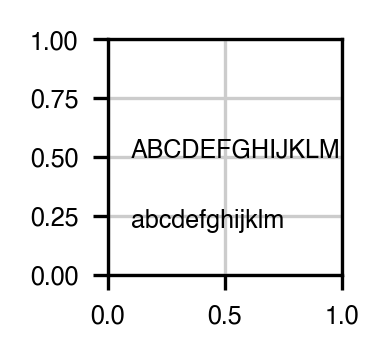

In [6]:
setfontsize()
fig,ax = plt.subplots(1,1,figsize=(1,1), dpi=300)
ax.text(0.1,0.5,'ABCDEFGHIJKLM')
ax.text(0.1,0.2, 'abcdefghijklm')
plt.show()

In [7]:
from matplotlib.image import imread
from tempfile import NamedTemporaryFile

def get_size(fig, dpi=300):
    with NamedTemporaryFile(suffix='.png') as f:
        fig.savefig(f.name, bbox_inches='tight', dpi=dpi)
        height, width, _channels = imread(f.name).shape
        return width / dpi, height / dpi

def set_size(fig, size, dpi=300, eps=1e-2, give_up=2, min_size_px=10):
    target_width, target_height = size
    set_width, set_height = target_width, target_height # reasonable starting point
    deltas = [] # how far we have
    while True:
        fig.set_size_inches([set_width, set_height])
        actual_width, actual_height = get_size(fig, dpi=dpi)
        set_width *= target_width / actual_width
        set_height *= target_height / actual_height
        deltas.append(abs(actual_width - target_width) + abs(actual_height - target_height))
        if deltas[-1] < eps:
            return True
        if len(deltas) > give_up and sorted(deltas[-give_up:]) == deltas[-give_up:]:
            return False
        if set_width * dpi < min_size_px or set_height * dpi < min_size_px:
            return False

## Loading the data

Here we load the expression matrices and metadata, in anndata files.

In [8]:
file_prefix = '../Data/Processed/Big_Invivo'
file_suffix = '.loom'  

a6 = 'A1_06_D180'
a30 = 'A1_30_D180'
jh = 'JH_D2000'

ds_titles = {a6:'Donor A (day 180)', 
             a30:'Donor B (day 180)',
             jh:'Donor C (day 2000)'}

datasets = [a6, a30, jh]

# Sample filename:  Big_Invivo_A1_06_D180.loom
adata = {}
for ds in datasets:
    fn = file_prefix+'_'+ds+file_suffix
    print('Reading from {}'.format(fn))
    adata[ds] = anndata.read_loom(fn)
    adata[ds].var_names = adata[ds].var['gene_name']
    adata[ds].obs_names = adata[ds].obs['obs_names']

Reading from ../Data/Processed/Big_Invivo_A1_06_D180.loom


/Users/martinweissman/opt/miniconda3/envs/clonalomics/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Reading from ../Data/Processed/Big_Invivo_A1_30_D180.loom
Reading from ../Data/Processed/Big_Invivo_JH_D2000.loom


## Examination of clone populations

In [9]:
clonepops = {}
bigclones = {}

for ds in datasets:
    clonepops[ds] = adata[ds].obs.clone_id.value_counts()
    bigclones[ds] = list(clonepops[ds][:11].index)
    bigclones[ds] = [cl for cl in bigclones[ds] if cl[1:] != '0']

    
    cp_table = pd.DataFrame(clonepops[ds].loc[bigclones[ds]])
    cp_table.columns = ['Clone population']
    print('Largest 10 clones in {} with {} cells:'.format(ds_titles[ds], cp_table['Clone population'].sum()))
    display(cp_table.T)
    hrule()

Largest 10 clones in Donor A (day 180) with 205 cells:


A47  A48  A61  A154  A177  A3  A159  A39  A60  A9
Clone population   38   25   23    19    19  18    17   16   15  15

Largest 10 clones in Donor B (day 180) with 252 cells:


B39  B66  B8  B12  B102  B71  B24  B7  B44  B212
Clone population   45   35  27   26    24   23   19  19   18    16

Largest 10 clones in Donor C (day 2000) with 203 cells:


C35  C107  C154  C27  C87  C75  C29  C25  C67  C38
Clone population   29    25    24   24   21   18   16   16   16   14

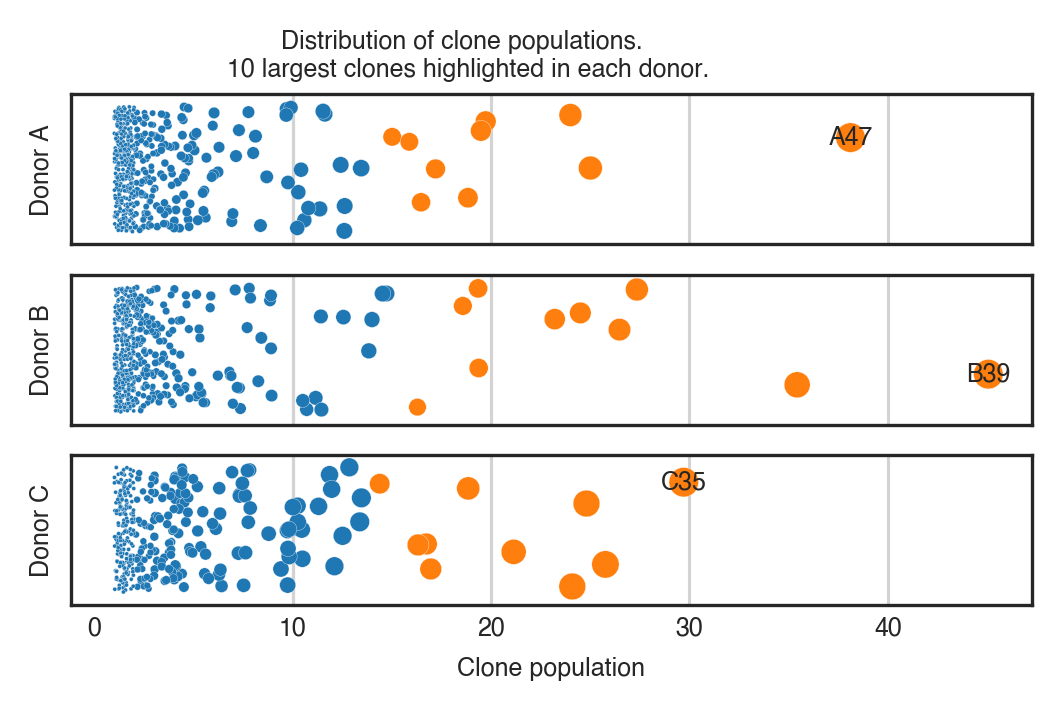

In [11]:
mm = 1/25.4
sns.set_style('white')
setfontsize()
figsize=(90*mm, 60*mm)
fig,ax = plt.subplots(3,1,figsize=figsize, dpi=300, sharex=True)

for j,ds in enumerate(datasets):
    ax[j].axvline(10, color='lightgray', linewidth=0.75)
    ax[j].axvline(20, color='lightgray', linewidth=0.75)
    ax[j].axvline(30, color='lightgray', linewidth=0.75)
    ax[j].axvline(40, color='lightgray', linewidth=0.75)
    cp = clonepops[ds]
    #display(cp)
    cpi = [cl for cl in cp.index if cl[1:] != '0']
    cp = cp.loc[cpi]
    pl_df = pd.DataFrame(index=cpi)
    pl_df['x'] = cp.values + np.random.random(len(cp.values))
    pl_df['y'] = np.random.random(len(cp.values))
    pl_df['pop'] = cp.values
    pl_df['clone'] = pl_df.index
    pl_df['isbig'] = pl_df['clone'].isin(bigclones[ds])
    sns.scatterplot(x='x', y='y', size='pop', hue='isbig', sizes=(1,50), data=pl_df, ax=ax[j],
                   legend=False, zorder=10)
    ax[j].axvline(10, color='lightgray', linewidth=0.75)
    ax[j].set_yticks([])
    ax[j].set_ylim(-0.1,1.1)
    pl_df = pl_df.sort_values('pop')
    biggy = pl_df.iloc[-1]
    ax[j].text(biggy['x'], biggy['y'], biggy['clone'], ha='center', va='center', zorder=20)

ax[0].set_ylabel('Donor A')
ax[1].set_ylabel('Donor B')
ax[2].set_ylabel('Donor C')

ax[2].set_xlabel('Clone population')
ax[2].tick_params(axis='x', pad=-1)

plt.suptitle('Distribution of clone populations. \n 10 largest clones highlighted in each donor.', y=1.01)
set_size(fig, figsize)
plt.savefig('Panels/Clonepops.pdf'.format(ds), bbox_inches='tight')
plt.show()

Here we create new datasets, with just the cells from the 10 biggest clones.

In [12]:
ads = {}
for ds in datasets:
    bc_cells = adata[ds].obs['clone_id'].isin(bigclones[ds])
    bc_cells = bc_cells[bc_cells].index
    ads[ds] = adata[ds][bc_cells, :]
    print(ds, ads[ds])
    hrule()

A1_06_D180 View of AnnData object with n_obs × n_vars = 205 × 8468
    obs: 'Donor', 'DonorDay', 'Timepoint', 'batch', 'clone_id', 'is_clone0', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'log1p_total_counts_mt', 'n_counts', 'n_genes', 'n_genes_by_counts', 'obs_names', 'pct_counts_mt', 'total_counts', 'total_counts_mt'
    var: 'GC_content', 'gene_name', 'highly_variable', 'highly_variable_rank', 'log1p_mean_counts', 'log1p_total_counts', 'mean_counts', 'means', 'mt', 'n_cells', 'n_cells_by_counts', 'n_counts', 'pct_dropout_by_counts', 'total_counts', 'transcript_length', 'variances', 'variances_norm'
A1_30_D180 View of AnnData object with n_obs × n_vars = 252 × 8658
    obs: 'Donor', 'DonorDay', 'Timepoint', 'batch', 'clone_id', 'is_clone0', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'log1p_total_counts_mt', 'n_counts', 'n_genes', 'n_genes_by_counts', 'obs_names', 'pct_counts_mt', 'total_counts', 'total_counts_mt'
    var: 'GC_content', 'gene_name', 'highly_variable', 'high

# Adding permuted labels to AnnData objects

We will be running permutation tests to find clonal signals in our data.  For this purpose, we will permute the clone-labels on many of our cells (within each celltype and brain).  

The following is a specialized tool for permutation tests.  It produes permutations which disrupt existing group structures.  For example, if we want 10 permutations of clone labels, we produce 100 permutations instead.  We "score" these by looking at how many distinct labels each old clone receives.  I.e., if an old clone A has three cells 1,2,3, and these are assigned labels B,C,D instead of A,A,A, then we give it a score of 3 (three distinct labels).  We then take the top 10 permutations, by this score.  

This mitigates some issues with clonal structure being preserved by some permutations and not by others... a significant issue when there are pretty small samples.

In [13]:
def make_shuff(meta, no_shuffs=10, topratio = 10):
    tot_shuffs = no_shuffs * topratio
    ms_df = pd.DataFrame(index=meta.index, columns=range(tot_shuffs))
    ms_df = pd.concat([meta.astype(str) for j in range(tot_shuffs)], axis=1)
    
    ms_vals = ms_df.values
    [np.random.shuffle(x) for x in ms_vals.T]
    
    ms_df.columns = ['Shuffle_{}'.format(j) for j in range(tot_shuffs)]
    scores = ms_df.groupby(meta).nunique().sum()
    good_shuffs = scores.sort_values()[-no_shuffs:].index
    ms_df = ms_df[good_shuffs].astype('category')
    ms_df.columns = ['Shuffle_{}'.format(j) for j in range(no_shuffs)]
    return ms_df

In [14]:
no_shuffs = 1100

for ds in datasets:
    clone_shuffs = make_shuff(ads[ds].obs.clone_id, no_shuffs = no_shuffs)
    shuff_cols = clone_shuffs.columns
    ads[ds].obs[shuff_cols] = clone_shuffs
    print('Shuffled clone labels produced for dataset with {} cells'.format(ads[ds].shape[0]))

Trying to set attribute `.obs` of view, copying.


Shuffled clone labels produced for dataset with 205 cells


Trying to set attribute `.obs` of view, copying.


Shuffled clone labels produced for dataset with 252 cells


Trying to set attribute `.obs` of view, copying.


Shuffled clone labels produced for dataset with 203 cells


In [15]:
from time import time
from scipy.stats import f_oneway

def make_pvals(ad, real_group, shuffle_label = 'Shuffle', no_shuffs=100):
    '''
    Expects an AnnData object ad.
    real_group is usually "cloneID", or the equivalent.
    Also expects a lot of shuffled real_group labels, called
    Shuffle_0, Shuffle_1, up to Shuffle_n, where n = no_shuffs.
    real_group and shuffles should be within the ad.obs dataframe.
    Computes p-values by applying scipy's f_oneway to each column of shuffled labels.
    Vectorized for all genes at once.
    '''
    before = time()    
    cols = [real_group] + [shuffle_label + '_' + str(j) for j in range(no_shuffs)]
    pval_df = pd.DataFrame(columns=cols)

    groups = ad.obs[real_group].unique()
    ad_df = ad.to_df()
    pval_df = ad.obs[cols].apply(lambda col : f_oneway(*[ad_df[col == k] for k in groups])[1])
    pval_df.index = ad.var_names
    after = time()
    print('{:1.0f} seconds to compute ANOVA F p-values for {} cells and {} groups.'.format(after - before,
                                                                                          ad.shape[0], len(groups)))
    return pval_df

In [16]:
all_pvals = {}
for ds in datasets:
    all_pvals[ds] = make_pvals(ads[ds], 'clone_id', no_shuffs = no_shuffs)

48 seconds to compute ANOVA F p-values for 205 cells and 10 groups.
58 seconds to compute ANOVA F p-values for 252 cells and 10 groups.
47 seconds to compute ANOVA F p-values for 203 cells and 10 groups.


In [17]:
all_pvals[ds].head()

clone_id  Shuffle_0  Shuffle_1  Shuffle_2  Shuffle_3  Shuffle_4  \
gene_name                                                                       
WASH7P        0.605808   0.715809   0.383375   0.019317   0.255114   0.488866   
MTND1P23      0.468655   0.283853   0.792414   0.778625   0.427988   0.081937   
MTND2P28      0.154896   0.245585   0.233129   0.512340   0.860578   0.574587   
hsa-mir-6723  0.541638   0.101577   0.387777   0.021541   0.063532   0.705493   
RP5-857K21.7  0.614027   0.719428   0.962697   0.189870   0.734790   0.933209   

              Shuffle_5  Shuffle_6  Shuffle_7  Shuffle_8  ...  Shuffle_1090  \
gene_name                                                 ...                 
WASH7P         0.670120   0.709503   0.148679   0.661421  ...      0.194588   
MTND1P23       0.142246   0.701397   0.635565   0.656898  ...      0.699087   
MTND2P28       0.599157   0.897582   0.440099   0.779118  ...      0.724228   
hsa-mir-6723   0.111199   0.848246   0.880765   0.384336  ...      0.753773   
RP5-857K21.7   0.829301   0.330999   0.380738   0.880755  ...      0.416879   

              Shuffle_1091  Shuffle_1092  Shuffle_1093  Shuffle_1094  \
gene_name                                                              
WASH7P            0.932803      0.756708      0.497668      0.602791   
MTND1P23          0.952892      0.482462      0.290878      0.694890   
MTND2P28          0.582043      0.017669      0.514177      0.923539   
hsa-mir-6723      0.031553      0.710115      0.794919      0.185614   
RP5-857K21.7      0.167983      0.037342      0.201768      0.566529   

              Shuffle_1095  Shuffle_1096  Shuffle_1097  Shuffle_1098  \
gene_name                                                              
WASH7P            0.584087      0.610500      0.962975      0.720721   
MTND1P23          0.045655      0.659714      0.008857      0.164253   
MTND2P28          0.206325      0.278360      0.448239      0.702829   
hsa-mir-6723      0.152565      0.213459      0.615312      0.162646   
RP5-857K21.7      0.478333      0.076579      0.445871      0.888234   

              Shuffle_1099  
gene_name                   
WASH7P            0.733497  
MTND1P23          0.090308  
MTND2P28          0.868308  
hsa-mir-6723      0.547717  
RP5-857K21.7      0.453706  

[5 rows x 1101 columns]

In [18]:
import matplotlib.patches as patches
def permplot(ds, pcut=0.01, figwidth = None, xrange=None):
    if figwidth:
        figsize=(figwidth, 20*mm)
    else:
        figsize = (50*mm, 30*mm)
    sns.set_style('white', rc={"axes.facecolor": (0, 0, 0, 0)})
    setfontsize()
    fig,ax = plt.subplots(1,1, figsize=figsize, dpi=300, 
                          gridspec_kw={'wspace':0.2})
    num_sig = (all_pvals[ds] < pcut).sum()
    sig_med = num_sig.drop('clone_id').median()
    sig_high = num_sig.drop('clone_id').quantile(0.95)
    nsig = num_sig['clone_id']
    N = len(ads[ds])
    K = ads[ds].obs.clone_id.nunique()
            
    sns.kdeplot(num_sig.drop('clone_id'), clip_on=False, shade=True, 
                alpha=0.4, ax=ax, legend=False)
    sns.kdeplot(num_sig.drop('clone_id'), clip_on=False, color='w', 
                alpha=1, ax=ax, legend=False)
    kde_curve = ax.lines[0]
    kde_y = kde_curve.get_ydata()
    ky_max = kde_y.max()
    ax.set_yticks([])
    ax.set_title('')
    ax.set_ylim(0,ky_max*1.5)
            
    #ax.text(0, 0.75, '{}, N={}, K={}'.format(ds_titles[ds],N,K), fontweight="bold", 
    #        color='black', ha="left", va="center", transform=ax.transAxes)
            
    ax.axvline(nsig, ymax=0.3, color='red')
    ax.axvline(sig_med, ymax=0.3, linewidth=0.5, color='blue')
    ax.axvline(sig_high, ymax=0.3, linewidth=0.5, color='orange')
    trans = ax.get_xaxis_transform()
    #ax.text(0, .65, 'N={}, K={}.'.format(N,K), fontweight="bold", 
    #        color='black', ha="left", va="center", transform=ax.transAxes)
    
    ax.text(0.1, 1.0, ds_titles[ds] + ', N={}'.format(N),
           color='black', ha="left", va="center", transform=ax.transAxes)
    ax.text(0.1, .85, '{:d} excess clonal genes.'.format(int(nsig - sig_med)),  
            color='black', ha="left", va="center", transform=ax.transAxes)
            

    ar_y = ky_max * 0.45
    arr = patches.FancyArrowPatch((sig_med, ar_y), (nsig, ar_y), arrowstyle='<->', 
                                  shrinkA=0, shrinkB=0,
                                  mutation_scale=5, linewidth=0.5, color='k', zorder=10)
    ax.add_patch(arr)
            
    if nsig > (sig_high+20):
        ax.text(0.1, .7, '{:d} beyond 95th percentile.'.format(int(nsig - sig_high)),  
                color='black', ha="left", va="center", transform=ax.transAxes)
        arr = patches.FancyArrowPatch((sig_high, ar_y*0.7), (nsig, ar_y*0.7), arrowstyle='<->',
                                      shrinkA=0, shrinkB=0,
                                      mutation_scale=5, linewidth=0.5, color='k', zorder=10)
        ax.add_patch(arr)
                
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params(axis='x', pad=-1)
    if xrange:
        ax.set_xlim(xrange)
    sns.despine(left=True)
    set_size(fig, figsize)
    plt.savefig('Panels/{}_excess_genes.pdf'.format(ds), bbox_inches='tight')
    plt.show()

In [19]:
mm = 1 / 25.4

A1_06_D180


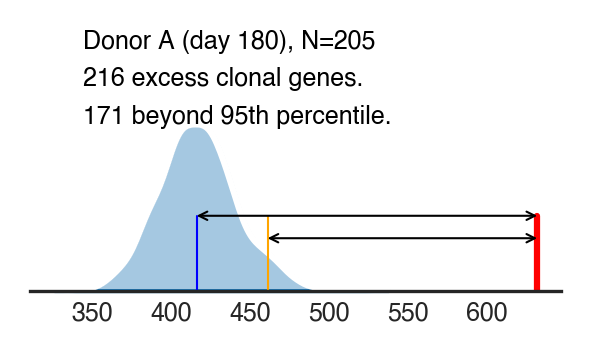

A1_30_D180


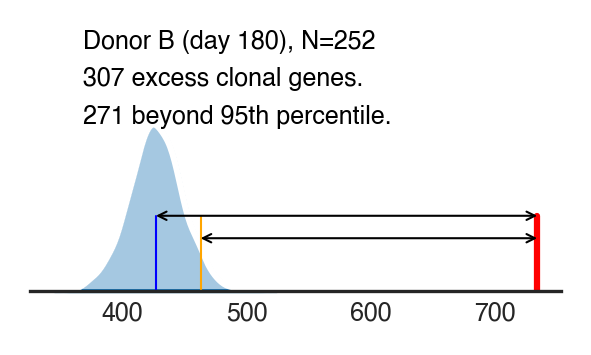

JH_D2000


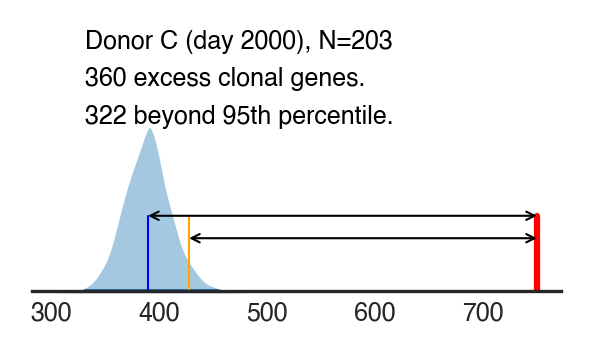

In [20]:
for ds in datasets:
    print(ds)
    permplot(ds, pcut=0.05)
    hrule()

In [21]:
weaksig_genes = {}
for ds in datasets:
    ww = (all_pvals[ds].clone_id < 0.01)
    weaksig_genes[ds] = ww[ww].index
    print('{} weakly significant genes found in {}'.format(len(weaksig_genes[ds]), ds))


218 weakly significant genes found in A1_06_D180
266 weakly significant genes found in A1_30_D180
309 weakly significant genes found in JH_D2000


In [22]:
decoy_genes = {}
for ds in datasets:
    ww = (all_pvals[ds].Shuffle_0 < 0.01)
    decoy_genes[ds] = ww[ww].index
    print('{} decoy significant genes found in {}'.format(len(decoy_genes[ds]), ds))

85 decoy significant genes found in A1_06_D180
95 decoy significant genes found in A1_30_D180
83 decoy significant genes found in JH_D2000


In [23]:
all_pvals[a30]

clone_id  Shuffle_0  Shuffle_1  Shuffle_2  Shuffle_3  Shuffle_4  \
gene_name                                                                       
WASH7P        0.978476   0.458852   0.414537   0.206355   0.421303   0.104468   
MTND1P23      0.067980   0.204902   0.014654   0.871482   0.071736   0.183536   
MTND2P28      0.004363   0.613409   0.611204   0.330588   0.404206   0.743504   
hsa-mir-6723  0.293363   0.812964   0.394273   0.849829   0.970650   0.245143   
RP5-857K21.7  0.819168   0.998092   0.579182   0.542602   0.326691   0.967636   
...                ...        ...        ...        ...        ...        ...   
UTY           0.695752   0.752322   0.447959   0.104410   0.377388   0.110996   
PSMA6P1       0.273142   0.607644   0.302580   0.560638   0.246438   0.609556   
TXLNG2P       0.989244   0.166058   0.620162   0.228580   0.178927   0.950746   
KDM5D         0.163192   0.803767   0.535996   0.785056   0.467221   0.937272   
EIF1AY        0.580596   0.500626   0.205669   0.500970   0.093216   0.922832   

              Shuffle_5  Shuffle_6  Shuffle_7  Shuffle_8  ...  Shuffle_1090  \
gene_name                                                 ...                 
WASH7P         0.773394   0.258140   0.341725   0.189887  ...      0.181605   
MTND1P23       0.247282   0.749901   0.272842   0.282259  ...      0.096444   
MTND2P28       0.213840   0.529815   0.207943   0.716888  ...      0.788927   
hsa-mir-6723   0.008475   0.899288   0.116497   0.317201  ...      0.554140   
RP5-857K21.7   0.203822   0.533845   0.160445   0.315185  ...      0.784705   
...                 ...        ...        ...        ...  ...           ...   
UTY            0.748190   0.665542   0.728425   0.853361  ...      0.157152   
PSMA6P1        0.709920   0.395055   0.356859   0.434833  ...      0.419761   
TXLNG2P        0.468147   0.106775   0.865495   0.426339  ...      0.035972   
KDM5D          0.796431   0.078941   0.703016   0.657836  ...      0.773026   
EIF1AY         0.525816   0.684853   0.287308   0.052238  ...      0.699008   

              Shuffle_1091  Shuffle_1092  Shuffle_1093  Shuffle_1094  \
gene_name                                                              
WASH7P            0.979917      0.683877      0.012424      0.879535   
MTND1P23          0.658108      0.205930      0.488397      0.072328   
MTND2P28          0.232730      0.604293      0.861845      0.851394   
hsa-mir-6723      0.224849      0.994081      0.030229      0.646328   
RP5-857K21.7      0.562616      0.151488      0.937713      0.650833   
...                    ...           ...           ...           ...   
UTY               0.088619      0.508370      0.028910      0.987239   
PSMA6P1           0.423161      0.854351      0.397561      0.804015   
TXLNG2P           0.274214      0.900729      0.487339      0.596946   
KDM5D             0.592521      0.391827      0.587483      0.303048   
EIF1AY            0.230168      0.356983      0.249541      0.427631   

              Shuffle_1095  Shuffle_1096  Shuffle_1097  Shuffle_1098  \
gene_name                                                              
WASH7P            0.353715      0.028577      0.996792      0.821094   
MTND1P23          0.925353      0.091628      0.983167      0.209586   
MTND2P28          0.569410      0.439376      0.401511      0.047102   
hsa-mir-6723      0.256254      0.236042      0.032310      0.228751   
RP5-857K21.7      0.613079      0.443237      0.143353      0.476254   
...                    ...           ...           ...           ...   
UTY               0.754389      0.375467      0.400219      0.685318   
PSMA6P1           0.795024      0.714206      0.558131      0.426503   
TXLNG2P           0.957840      0.678496      0.266742      0.417086   
KDM5D             0.295328      0.889561      0.736929      0.368383   
EIF1AY            0.454798      0.899676      0.227767      0.629101   

              Shuffle_1099  
gene_name                   


In [24]:
ag_a6 = all_pvals[a6].index
ag_a30 = all_pvals[a6].index
ag_jh = all_pvals[a6].index
all_genes_invivo = pd.Series(index=list(set(ag_a6) | set(ag_a30) | set(ag_jh)))
print(len(all_genes_invivo))
all_genes_invivo.to_csv('../Data/all_genes_invivo.csv')

cg_a6 = all_pvals[a6]['clone_id'].sort_values()[:200].index
cg_a30 = all_pvals[a30]['clone_id'].sort_values()[:200].index
cg_jh = all_pvals[jh]['clone_id'].sort_values()[:200].index
clonal_genes_invivo = pd.Series(index=list(set(cg_a6) | set(cg_a30) | set(cg_jh)))
print(len(clonal_genes_invivo))
clonal_genes_invivo.to_csv('../Data/clonal_genes_invivo.csv')

cdg_a6 = all_pvals[a6]['Shuffle_1'].sort_values()[:200].index
cdg_a30 = all_pvals[a30]['Shuffle_1'].sort_values()[:200].index
cdg_jh = all_pvals[jh]['Shuffle_1'].sort_values()[:200].index
clonal_decoy_genes_invivo = pd.Series(index=list(set(cdg_a6) | set(cdg_a30) | set(cdg_jh)))
print(len(clonal_decoy_genes_invivo))
clonal_decoy_genes_invivo.to_csv('../Data/clonal_decoy_genes_invivo.csv')

8468
488
592


<ipython-input-24-715c63d2eefb>:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  all_genes_invivo = pd.Series(index=list(set(ag_a6) | set(ag_a30) | set(ag_jh)))
<ipython-input-24-715c63d2eefb>:11: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  clonal_genes_invivo = pd.Series(index=list(set(cg_a6) | set(cg_a30) | set(cg_jh)))
<ipython-input-24-715c63d2eefb>:18: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  clonal_decoy_genes_invivo = pd.Series(index=list(set(cdg_a6) | set(cdg_a30) | set(cdg_jh)))


In [25]:
len(clonal_genes_invivo)

488

## Identifying clonal genes

We use the permuted clone labels together with the ANOVA F p-values to identify clonal genes while managing false discovery rate.

In [26]:
for ds in datasets:
    ads[ds].var['nz_ratio'] = (ads[ds].to_df() > 0).sum() / ads[ds].n_obs

In [27]:
shuff_cols = ['Shuffle_'+str(j) for j in range(1000)]
test_cols = ['clone_id'] + ['Shuffle_'+str(j) for j in range(1000,1100)]

In [28]:
def adj_pval_binned(ad, pv, test_cols, shuff_cols, bins=20, corrected=True, verbose=False):
    nz_cut = pd.qcut(ad.var.nz_ratio, bins)
    p_adj_list = []
    for nz_bin in nz_cut.unique():
        if verbose:
            print('Processing genes with nonzero ratio in {}'.format(nz_bin))
        genes_bin = nz_cut[nz_cut == nz_bin].index
        bin_pvals = pv.loc[genes_bin]
        shuff_pvals = bin_pvals[shuff_cols]
        now_time = time()
        shuff_pvals = np.sort(shuff_pvals, axis=None)
        then_time = time()
        if verbose:
            print('Sorting {} p-values took {} seconds.'.format(len(shuff_pvals), then_time - now_time))
        test_pvals = bin_pvals[test_cols].values
        now_time = time()
        places = np.searchsorted(shuff_pvals, test_pvals )
        then_time = time()
        if verbose:
            print('Finding places for {} p-values in sorted list took {} seconds.'.format(test_pvals.shape, 
                                                                                         then_time-now_time))
        denominator = 1 + len(shuff_pvals)
        numerator = 1 + places
        p_adj = pd.DataFrame(numerator / denominator, index=bin_pvals.index, columns=test_cols)
        if corrected:
            corrector = test_pvals.shape[0]
            p_adj = (p_adj * corrector).clip(0,1)
        p_adj_list.append(p_adj)
    return pd.concat(p_adj_list)

In [29]:
p_permadj = {}
for ds in datasets:
    print('Adjusting p-values for {}'.format(ds))
    p_permadj[ds] = adj_pval_binned(ads[ds], all_pvals[ds], test_cols, shuff_cols, corrected=True)

Adjusting p-values for A1_06_D180
Adjusting p-values for A1_30_D180
Adjusting p-values for JH_D2000


In [30]:
sig_genes = {}
for ds in datasets:
    sig_df = (p_permadj[ds] < 0.05)
    #print(ds, sig_df.sum())
    sig_genes[ds] = list(sig_df.clone_id[sig_df.clone_id].index)
    sig_genes[ds].sort()
    print('The {} significant genes for {} are {}'.format(len(sig_genes[ds]), ds, ', '.join(sig_genes[ds])))
    FDs = sig_df.sum()[1:].mean()
    print('{} expected by chance.'.format(FDs))
    hrule()

The 36 significant genes for A1_06_D180 are C1orf228, CCL4, CCR7, CD300A, CD7, COL18A1, EEF1A1P6, FCGR3A, FCRL6, FGFBP2, GNLY, GPR56, GZMB, GZMH, GZMK, IFNG-AS1, IL7R, ITGAM, KCNN4, KLRB1, KLRD1, LAIR2, LTB, NKG7, NOSIP, PAX8-AS1, RHOH, RP11-23P13.6, RPL13, RPL4, RPLP0, RPS12, RPSA, S1PR5, SELL, TCF7
0.96 expected by chance.
The 41 significant genes for A1_30_D180 are ALOX5AP, AMICA1, ARPC2, B2M, C1orf162, CCL5, CD160, CD28, CD300A, CD5, DDX10, DFNB31, GFPT2, GNLY, GPR56, GZMH, HAVCR2, HLA-DRB1, HLA-DRB5, HOPX, IL7R, ITGB2, ITM2A, KLRB1, KLRD1, KLRG1, MAT2A, MT-CO3, MT-ND2, MT-ND5, MVB12B, NSG1, PASK, RNVU1-19, RP11-23P13.6, RPL21, RPLP1, SATB1, SPON2, TSPYL2-1, ZNF683
1.01 expected by chance.
The 72 significant genes for JH_D2000 are AOAH, BZRAP1, CAMK4, CCR7, CD300A, CD63, COL6A2, CST7, CX3CR1, DGKA, DPP4, EEF1A1P5, EFHD2, F2R, FAM211A-AS1, FCGR3A, FCGR3B, FCRL3, FCRL6, FGFBP2, FGR, GNLY, GPR56, GZMB, GZMH, GZMK, HLA-B, HNRNPA1, IL2RB, IL7R, KLRB1, KLRC4-KLRK1, LDLRAP1, LGALS1, LTB, 

In [31]:
for ds in datasets:
    pser = p_permadj[ds].loc[sig_genes[ds], 'clone_id']
    pser.name = 'adjusted p-value'
    pser = pser.sort_values()
    filename = 'sig_genes_padj_'+ds+'.csv'
    pser.to_csv(filename)

In [32]:
p_sig = {}
for ds in datasets:
    p_sig[ds] = all_pvals[ds]['clone_id'].loc[sig_genes[ds]].sort_values()
    print(ds)
    display(p_sig[ds][:10])
    hrule()

A1_06_D180


gene_name
KLRB1       8.378546e-16
GZMH        1.048250e-10
C1orf228    2.270031e-10
GNLY        4.652515e-10
KLRD1       1.173311e-09
KCNN4       4.770846e-09
CD300A      9.681567e-09
SELL        1.059200e-08
PAX8-AS1    1.289730e-08
RPL13       4.766125e-08
Name: clone_id, dtype: float64

A1_30_D180


gene_name
GZMH            7.061145e-19
AMICA1          5.902643e-11
GNLY            9.728728e-11
GFPT2           5.350074e-09
RP11-23P13.6    2.310860e-08
HLA-DRB1        9.711400e-08
ALOX5AP         1.400472e-07
C1orf162        2.688030e-07
ZNF683          3.045156e-07
SPON2           4.243609e-07
Name: clone_id, dtype: float64

JH_D2000


gene_name
GZMB      1.115043e-27
TIGIT     8.814141e-25
ZNF683    7.351689e-22
GZMH      7.893963e-20
FCGR3B    1.248728e-19
FCGR3A    1.010242e-17
GZMK      1.294853e-14
LTB       1.052094e-13
BZRAP1    3.715543e-13
RPL13A    1.478246e-12
Name: clone_id, dtype: float64

#  Merged donor analysis

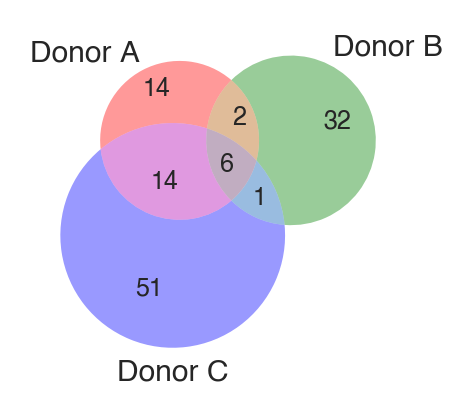

In [33]:
from matplotlib_venn import venn3

figsize=(40*mm, 40*mm)
fig,ax = plt.subplots(1,1,figsize=figsize, dpi=300)
setfontsize()

sigset = [set(sig_genes[datasets[j]]) for j in range(3)]

venn3([sigset[0], sigset[1], sigset[2]], set_labels = ('Donor A', 'Donor B', 'Donor C'), ax=ax)
common_genes = list(sigset[0] & sigset[1] & sigset[2])

set_size(fig, figsize)
plt.savefig('Panels/Venn.pdf'.format(ds), bbox_inches='tight')
plt.show()

In [34]:
sig_all = list(sigset[0] | sigset[1] | sigset[2])
print('{} genes found to be significant in at least one donor.'.format(len(sig_all)))
sig_common = list(sigset[0] & sigset[1] & sigset[2])
genes_shared = set.intersection(*[set(adata[ds].var_names) for ds in datasets])
print('The following genes are clonal in all donors: {}'.format(', '.join(sig_common)))
hrule()
sig_all = [gene for gene in sig_all if gene in genes_shared]
print('The following {} genes are clonal in at least one donor, and expressed by all.'.format(len(sig_all)))
print(', '.join(sig_all))

120 genes found to be significant in at least one donor.
The following genes are clonal in all donors: GNLY, KLRB1, GZMH, IL7R, GPR56, CD300A
The following 107 genes are clonal in at least one donor, and expressed by all.
GNLY, ZNF683, RPS18, DPP4, ALOX5AP, C1orf228, RPL13, RPS19, PASK, EEF1A1P6, RPLP1, AMICA1, RPL4P4, SELL, FGFBP2, PDE4B, DGKA, HNRNPA1, C1orf162, CD28, S1PR5, CD5, TPT1, SPOCK2, GPR56, KLRG1, DFNB31, RPSA, HLA-DRB1, AOAH, TSPYL2-1, CCL4, FCRL6, KLRD1, RPL21, CX3CR1, ARPC2, ITM2A, RPL32, HOPX, RPS6, ITGB2, SATB1, F2R, LTB, NKG7, FAM211A-AS1, PAX8-AS1, RPLP2, LGALS1, CST7, CD300A, NOSIP, RHOH, MAT2A, SNHG5, MT-ND5, RP11-23P13.6, BZRAP1, PRF1, RPL13A, TCF7, SPON2, RPL3, GZMK, CCL5, IL2RB, RPS4X, RPS14, RPS8, EEF1A1P5, LAIR2, RPS12, RPL19, MT-CO3, ZEB2, CD7, FGR, TTC38, EFHD2, MT-ND2, DDX10, FCGR3A, B2M, NSG1, HLA-B, KLRC4-KLRK1, FCGR3B, ITGAM, RPL18A, TMEM11, RPL4, TIGIT, CCR7, KLRB1, RPLP0, RPL5, GZMH, LDLRAP1, TBX21, GZMB, STOM, CAMK4, RPLP0P6, IL7R, CD63, RPL10A


In [35]:
def celltype_score(ad, ct_genes, ct_name='Celltype'):
    genelist = [gene for gene in ct_genes if gene in ad.var_names]
    ad_ct = ad[:,genelist].copy()
    sc.pp.scale(ad_ct) # z-scores
    sc.tl.pca(ad_ct, svd_solver='arpack', use_highly_variable=False)
    
    ad_ct.var['PC1_load'] = ad_ct.varm['PCs'][:,0]
    #display(ad_ct.var['PC1_load'])
    ct_unnorm = ad_ct.obsm['X_pca'][:,0]
    out,bins = pd.cut(ct_unnorm, 2, retbins=True)
    ct_norm = (ct_unnorm - bins[1]) / (bins[2] - bins[0])
    if ad_ct.var['PC1_load']['GZMH'] < 0:
        ct_norm = -ct_norm # Make sure positive = EFF consistently.
    ad_ct.obs[ct_name] = ct_norm
    ad.obs[ct_name] = ct_norm
    ad.var[ct_name+'_load'] = ad_ct.var['PC1_load']
    ad.var[ct_name+'_load'] = ad.var[ct_name+'_load'].fillna(0)
    if ad.var[ct_name+'_load']['GZMH'] < 0:
        ad.var[ct_name+'_load'] *= -1
    return ad

... storing 'Donor' as categorical
... storing 'DonorDay' as categorical
... storing 'batch' as categorical
... storing 'clone_id' as categorical


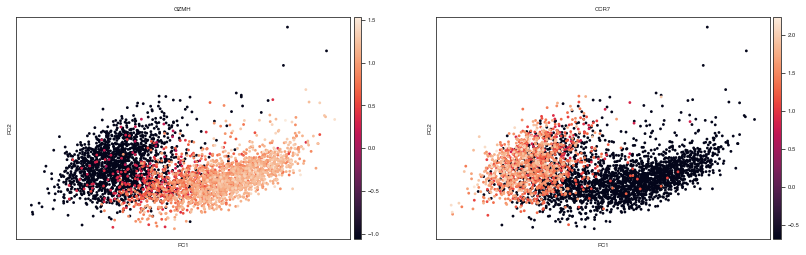

In [36]:
all_data = anndata.concat([adata[ds][:,sig_all] for ds in datasets]).copy()
all_data = celltype_score(all_data, sig_all, ct_name='CT')

adall_ct = all_data[:,sig_all].copy()
sc.pp.scale(adall_ct) # z-scores
sc.tl.pca(adall_ct, svd_solver='arpack', use_highly_variable=False)
sc.pl.pca(adall_ct, color=['GZMH','CCR7'], components=['1,2'])
plt.show()

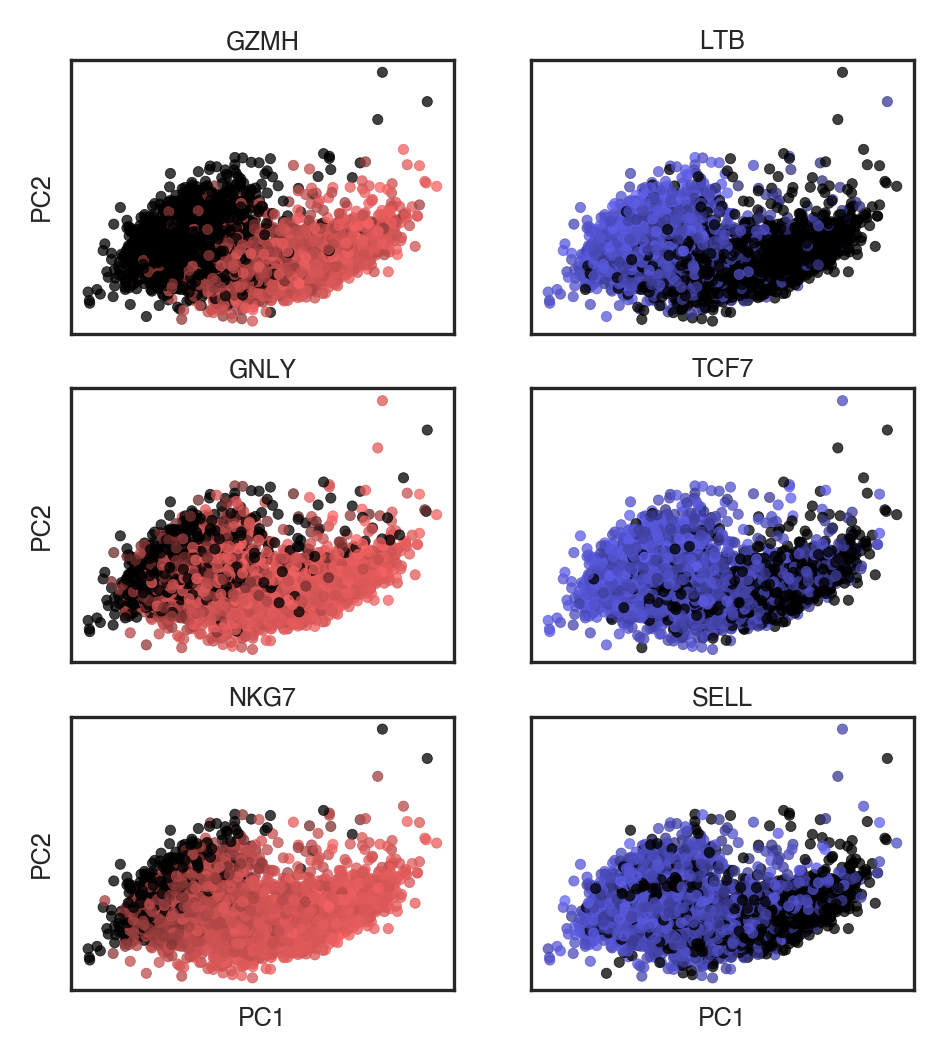

In [37]:
from matplotlib.colors import ListedColormap

figsize=(80*mm, 90*mm)
fig,ax = plt.subplots(3,2,figsize=figsize, dpi=300, sharex=True, sharey=True)
    
# Black-Red colormap
N = 256
vals = np.ones((N, 4))
vals[:, 0] = np.linspace(0, 1, N)
vals[:, 1] = np.linspace(0, 0.4, N)
vals[:, 2] = np.linspace(0, 0.4, N)
#vals[:, 3] = np.linspace(0,1,N)
redmap = ListedColormap(vals)
    
vals = np.ones((N, 4))
vals[:, 0] = np.linspace(0, 0.4, N)
vals[:, 1] = np.linspace(0, 0.4, N)
vals[:, 2] = np.linspace(0, 1, N)
#vals[:, 3] = np.linspace(0,1,N)
bluemap = ListedColormap(vals)
    
plot_df = pd.DataFrame(index=adall_ct.to_df().index)

gene_place = {(0,0) : 'GZMH',
             (0,1) : 'LTB',
             (1,0) : 'GNLY',
             (1,1) : 'TCF7',
             (2,0) : 'NKG7',
             (2,1) : 'SELL'}

plot_df['PC1'] = adall_ct.obsm['X_pca'][:,0]
plot_df['PC2'] = adall_ct.obsm['X_pca'][:,1]

for col,pal in enumerate([redmap,bluemap]):
    for row in [0,1,2]:
        gene = gene_place[(row,col)]
        plot_df[gene] = adall_ct.to_df()[gene]
        sns.scatterplot(x='PC1', y='PC2', hue=gene, data=plot_df, s=6, alpha=0.75, edgecolor=None, palette=pal,
                        ax=ax[row,col],  legend=False)
        ax[row,col].set_title(gene, y=0.95)

#if plot_df.sort_values(by='CCR7')['PC1'][:10].mean() < plot_df['PC1'].mean():
#    plot_df['PC1'] = -1*plot_df['PC1'] # Put high CCR7 on the left.
    

#ax[1].legend(bbox_to_anchor = (1.0,1.05), frameon=False)
ax[0,0].tick_params(axis='both', pad=-1)
ax[0,0].set_xticks([])
ax[0,0].set_yticks([])

set_size(fig, figsize)
plt.savefig('Panels/PC_All.pdf', bbox_inches='tight')
plt.show()

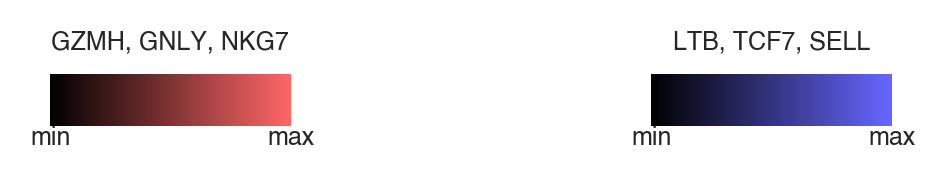

In [38]:
import matplotlib as mpl

figsize = (80*mm, 15*mm)
fig, ax = plt.subplots(1,2,figsize=figsize, dpi=300,
                      gridspec_kw={'wspace':1.5})
sns.set_style('white')
setfontsize()

cb = {}
cb[0] = fig.colorbar(mpl.cm.ScalarMappable(cmap=redmap),
                  cax=ax[0], orientation='horizontal')

cb[1] = fig.colorbar(mpl.cm.ScalarMappable(cmap=bluemap),
                  cax=ax[1], orientation='horizontal')

#[s.set_visible(False) for s in ax.spines.values()]
for j in range(2):
    cb[j].outline.set_visible(False)
    ax[j].tick_params(axis='x', pad=0, length=0)
    cb[j].set_ticks([0,0.5,1])
    cb[j].set_ticklabels(['min','','max'])

ax[0].set_title('GZMH, GNLY, NKG7')
ax[1].set_title('LTB, TCF7, SELL')

set_size(fig, figsize)
plt.savefig('Panels/PCA_Colorbar.pdf', bbox_inches='tight')
    
plt.show()

## Correlation matrix for clonal genes, combined donors.

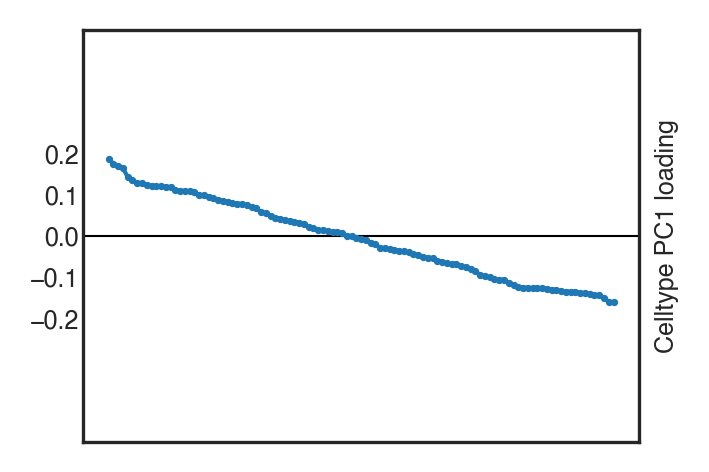

In [39]:
mm = 1 / 25.4

figsize=(60*mm,40*mm)
fig,ax = plt.subplots(1,1,figsize=figsize, dpi=300)
sns.set_style('whitegrid')
setfontsize()

ax.axhline(0, linewidth=0.5, color='k')

genelist = sig_all
plot_df = pd.DataFrame(all_data[:,genelist].var['CT_load'].copy())
plot_df['Gene'] = plot_df.index

plot_df.columns = ['Celltype loading','Gene']
plot_df = plot_df.sort_values(by='Celltype loading', ascending=False)
    #display(plot_df)
sns.lineplot(y='Celltype loading', x='Gene', data=plot_df, ax=ax, 
            linewidth=1.0, markers=True, marker='.', markersize=2.0, markeredgecolor=None)
ax.tick_params(axis='x', rotation=90, pad=-1)
ax.tick_params(axis='y', pad=1, length=0)
ax.set_ylim(-0.5,0.5)
ax.set_ylabel('Celltype PC1 loading')
ax.set_xlabel('')
ax.set_xticks([])
ax.set_yticks([-0.2,-.1,0,0.1,0.2])
ax.yaxis.set_label_position("right")
#ax.axhline(0.09, linewidth=0.5, color='k', linestyle='--')
#ax.axhline(-0.07, linewidth=0.5, color='k', linestyle='--')

set_size(fig, figsize)
plt.savefig('Panels/Celltype_loadings_all.pdf', bbox_inches='tight')
plt.show()

In [40]:
plot_df.to_csv('Celltype_loadings_invivo.csv')

In [41]:
genes_ct = (plot_df[plot_df['Celltype loading']**2 > 0.12**2]['Celltype loading']).index
genes_nct = [gene for gene in sig_all if gene not in genes_ct]
print('{} celltype genes are {}'.format(len(genes_ct), ', '.join(genes_ct)))
hrule()
print('{} other clonal genes are {}'.format(len(genes_nct), ', '.join(genes_nct)))

33 celltype genes are GZMH, FGFBP2, GPR56, GZMB, NKG7, GNLY, SPON2, ZEB2, ZNF683, HLA-B, FCGR3A, S1PR5, RPL18A, RPL4, RPLP1, RPLP2, RPS12, RPL13A, RPS4X, SELL, RPS14, TPT1, TCF7, RPLP0, RPL13, IL7R, RPL5, RPS8, RPL3, RPS6, CCR7, GZMK, LTB
74 other clonal genes are RPS18, DPP4, ALOX5AP, C1orf228, RPS19, PASK, EEF1A1P6, AMICA1, RPL4P4, PDE4B, DGKA, HNRNPA1, C1orf162, CD28, CD5, SPOCK2, KLRG1, DFNB31, RPSA, HLA-DRB1, AOAH, TSPYL2-1, CCL4, FCRL6, KLRD1, RPL21, CX3CR1, ARPC2, ITM2A, RPL32, HOPX, ITGB2, SATB1, F2R, FAM211A-AS1, PAX8-AS1, LGALS1, CST7, CD300A, NOSIP, RHOH, MAT2A, SNHG5, MT-ND5, RP11-23P13.6, BZRAP1, PRF1, CCL5, IL2RB, EEF1A1P5, LAIR2, RPL19, MT-CO3, CD7, FGR, TTC38, EFHD2, MT-ND2, DDX10, B2M, NSG1, KLRC4-KLRK1, FCGR3B, ITGAM, TMEM11, TIGIT, KLRB1, LDLRAP1, TBX21, STOM, CAMK4, RPLP0P6, CD63, RPL10A


In [42]:
plot_df.sort_values(by='Celltype loading')[-10:]

Celltype loading    Gene
gene_name                          
HLA-B              0.121743   HLA-B
ZNF683             0.123108  ZNF683
ZEB2               0.127101    ZEB2
SPON2              0.128536   SPON2
GNLY               0.134760    GNLY
NKG7               0.142993    NKG7
GZMB               0.164326    GZMB
GPR56              0.169735   GPR56
FGFBP2             0.175597  FGFBP2
GZMH               0.185671    GZMH

In [80]:
from scipy.spatial import distance
from scipy.cluster import hierarchy

corr_mat = adall_ct.to_df().corr()

row_linkage = hierarchy.linkage(
    distance.pdist(corr_mat), method='complete')

col_linkage = hierarchy.linkage(
    distance.pdist(corr_mat.T), method='complete')

In [81]:
corr_mat = corr_mat.iloc[hierarchy.leaves_list(row_linkage), hierarchy.leaves_list(col_linkage)]

In [105]:
mask = np.zeros_like(corr_mat)
for i in range(len(corr_mat)):
    for j in range(len(corr_mat)):
        if (i < j): # or (np.abs(corr_mat.iloc[i,j]) < 0.1):
            mask[i,j] = 1

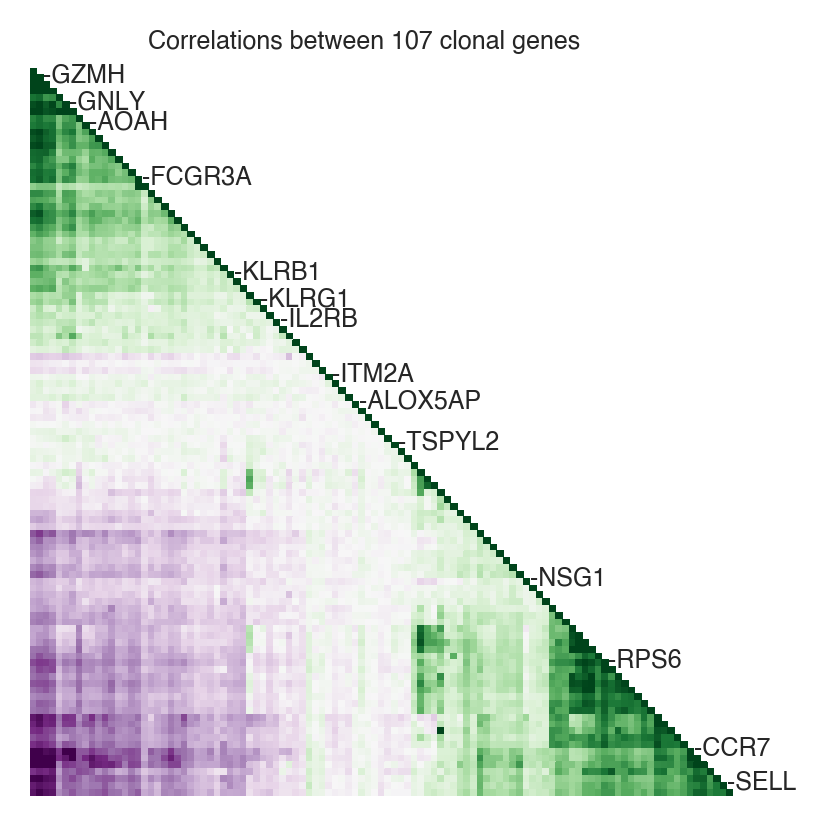

In [106]:
sns.set_style('white')
setfontsize()
figsize=(70*mm, 70*mm)
fig,ax = plt.subplots(1,1,figsize=figsize, dpi=300)

sns.heatmap(corr_mat, ax=ax, vmin=-0.5, vmax=0.5, cmap='PRGn', mask=mask,
            cbar=False, xticklabels=False, yticklabels=False)

ax.set_ylabel('')
ax.set_xlabel('')

ax.tick_params(axis='both', pad=-1)

#for j in range(len(corr_mat)):
#    gene = corr_mat.index[j]
#    if gene in genes_ct:
#        ax.text(j+1.5,j+1,'*', va='center', ha='center')

genelabel = ['CCR7','GZMH','C1orf2287','CD6','CD8B','NSG1','TSPYL2-1', 'RPS6', 'IL2RB', 'ITM2A', 
            'ANXA2', 'KLRC1', 'ALOX5AP', 'KLRB1', 'GNLY', 'KLRG1', 'BCR', 'SELL', 'AOAH', 'FCGR3A', 'FAM211A']
for j in range(len(corr_mat)):
    gene = corr_mat.index[j]
    if gene in genelabel:
        ax.text(j+1,j,'-'+gene.split('-')[0], va='center', ha='left', rotation=0)
#ax.set_yticks(list(genes_ct))
#for gene in genes_ct:
#    ax.text(0,gene,'*')

plt.suptitle('Correlations between {} clonal genes'.format(len(corr_mat)), x=0.55,y=0.95)
set_size(fig, figsize)
plt.savefig('Panels/Clonal_gene_correlation.pdf', bbox_inches='tight')
plt.show()

In [88]:
np.abs(corr_mat['GZMH']).describe()

count    107.000000
mean       0.287388
std        0.187377
min        0.002052
25%        0.147657
50%        0.272743
75%        0.414766
max        1.000000
Name: GZMH, dtype: float64

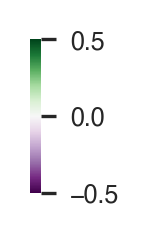

In [107]:
import matplotlib as mpl

figsize = (8*mm, 20*mm)
fig, ax = plt.subplots(1,1,figsize=figsize, dpi=300)
sns.set_style('white')
setfontsize()

cmap = mpl.cm.PRGn
norm = mpl.colors.Normalize(vmin=-0.5, vmax=0.5)

cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                  cax=ax, orientation='vertical')

#[s.set_visible(False) for s in ax.spines.values()]
cb.outline.set_visible(False)
ax.tick_params(axis='x', pad=0, length=0)
# cb.set_ticks([-0.5,-0.1,0.1,0.5])
# ax.add_patch(plt.Rectangle((-1,-0.1), 2, 0.2, color='white', linewidth=0))

set_size(fig, figsize)
plt.savefig('Panels/Corrmap_colorbar.pdf', bbox_inches='tight')
    
plt.show()

In [48]:
print(sig_all)

['GNLY', 'ZNF683', 'RPS18', 'DPP4', 'ALOX5AP', 'C1orf228', 'RPL13', 'RPS19', 'PASK', 'EEF1A1P6', 'RPLP1', 'AMICA1', 'RPL4P4', 'SELL', 'FGFBP2', 'PDE4B', 'DGKA', 'HNRNPA1', 'C1orf162', 'CD28', 'S1PR5', 'CD5', 'TPT1', 'SPOCK2', 'GPR56', 'KLRG1', 'DFNB31', 'RPSA', 'HLA-DRB1', 'AOAH', 'TSPYL2-1', 'CCL4', 'FCRL6', 'KLRD1', 'RPL21', 'CX3CR1', 'ARPC2', 'ITM2A', 'RPL32', 'HOPX', 'RPS6', 'ITGB2', 'SATB1', 'F2R', 'LTB', 'NKG7', 'FAM211A-AS1', 'PAX8-AS1', 'RPLP2', 'LGALS1', 'CST7', 'CD300A', 'NOSIP', 'RHOH', 'MAT2A', 'SNHG5', 'MT-ND5', 'RP11-23P13.6', 'BZRAP1', 'PRF1', 'RPL13A', 'TCF7', 'SPON2', 'RPL3', 'GZMK', 'CCL5', 'IL2RB', 'RPS4X', 'RPS14', 'RPS8', 'EEF1A1P5', 'LAIR2', 'RPS12', 'RPL19', 'MT-CO3', 'ZEB2', 'CD7', 'FGR', 'TTC38', 'EFHD2', 'MT-ND2', 'DDX10', 'FCGR3A', 'B2M', 'NSG1', 'HLA-B', 'KLRC4-KLRK1', 'FCGR3B', 'ITGAM', 'RPL18A', 'TMEM11', 'RPL4', 'TIGIT', 'CCR7', 'KLRB1', 'RPLP0', 'RPL5', 'GZMH', 'LDLRAP1', 'TBX21', 'GZMB', 'STOM', 'CAMK4', 'RPLP0P6', 'IL7R', 'CD63', 'RPL10A']


In [49]:
for ds in datasets:
    adata[ds].obs['CT'] = all_data.obs['CT']
    ads[ds].obs['CT'] = all_data.obs['CT']

Here we create a special "type" for clone_id, to sort it by celltype scores.

In [50]:
clonetype = {}
for ds in datasets:
    clone_cts = ads[ds].obs.groupby('clone_id').CT.mean().sort_values()
    clonetype[ds] = pd.CategoricalDtype(categories=list(clone_cts.index), ordered=True)
    ads[ds].obs['clone_id'] = ads[ds].obs['clone_id'].astype(clonetype[ds])

In [51]:
udist = np.random.uniform(0,1,1000)
sdist = np.random.normal(0.5,2,20)

In [52]:
ss.kstest(sdist,udist)

KstestResult(statistic=0.473, pvalue=0.00015455111408324562)

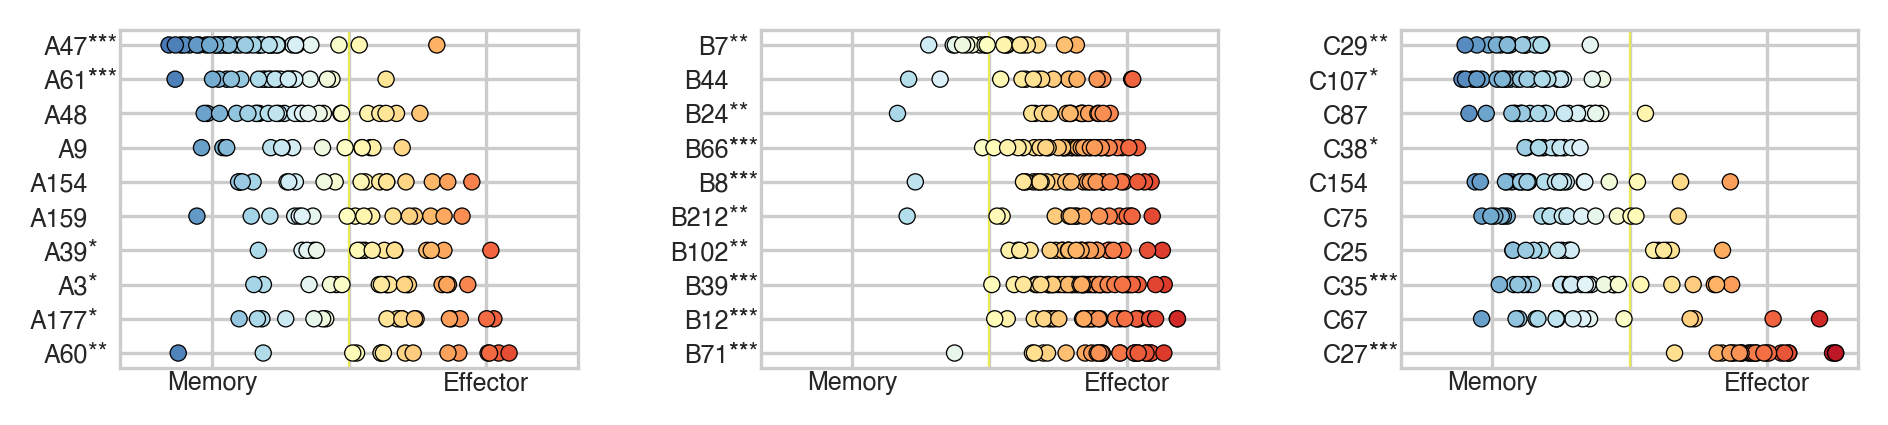

In [54]:
figsize=(160*mm,36*mm)
fig,ax = plt.subplots(1,3,figsize=figsize, sharex=True, dpi=300,
                     gridspec_kw={'wspace':0.4})

sns.set_style('whitegrid')
setfontsize()

for j,ds in enumerate(datasets[:3]):
    pop_dist = adata[ds].obs.CT
    
    ax[j].axvline(0, color='yellow', linewidth=0.5, alpha=0.6, zorder=1)
    sns.scatterplot(y='clone_id', x='CT', hue='CT', data=ads[ds].obs, ax=ax[j],
                    palette='RdYlBu_r', edgecolor='k', s=15, legend=False,
                   zorder=2, hue_norm=(-0.5,0.5))
    for clone in ads[ds].obs.clone_id.unique():
        cl_dist = ads[ds].obs[ads[ds].obs.clone_id == clone].CT
        ks = ss.kstest(pop_dist, cl_dist)
        if ks.pvalue < 0.001:
            ax[j].text(-0.57,clone,'***', va='center')
        if ks.pvalue < 0.01:
            ax[j].text(-0.57,clone,'**', va='center')
        elif ks.pvalue < 0.05:
            ax[j].text(-0.57,clone,'*', va='center')
        #print(clone,ks.pvalue)
    ax[j].tick_params(axis='x', pad=0)
    ax[j].set_xlabel('')
    ax[j].set_ylabel('')
    ax[j].tick_params(axis='y', pad=4.2)
    ax[j].set_xticks([-0.3,0,0.3])
    ax[j].set_xlim(-0.5,0.5)
    ax[j].set_xticklabels(['Memory','','Effector'], va='center')
    N = len(ads[ds].obs)
    #ax[j].set_title(ds_titles[ds] + ', N={}'.format(N), y=0.97)

set_size(fig, figsize)
plt.savefig('Panels/Celltype_clonal.pdf', bbox_inches='tight')
plt.show()

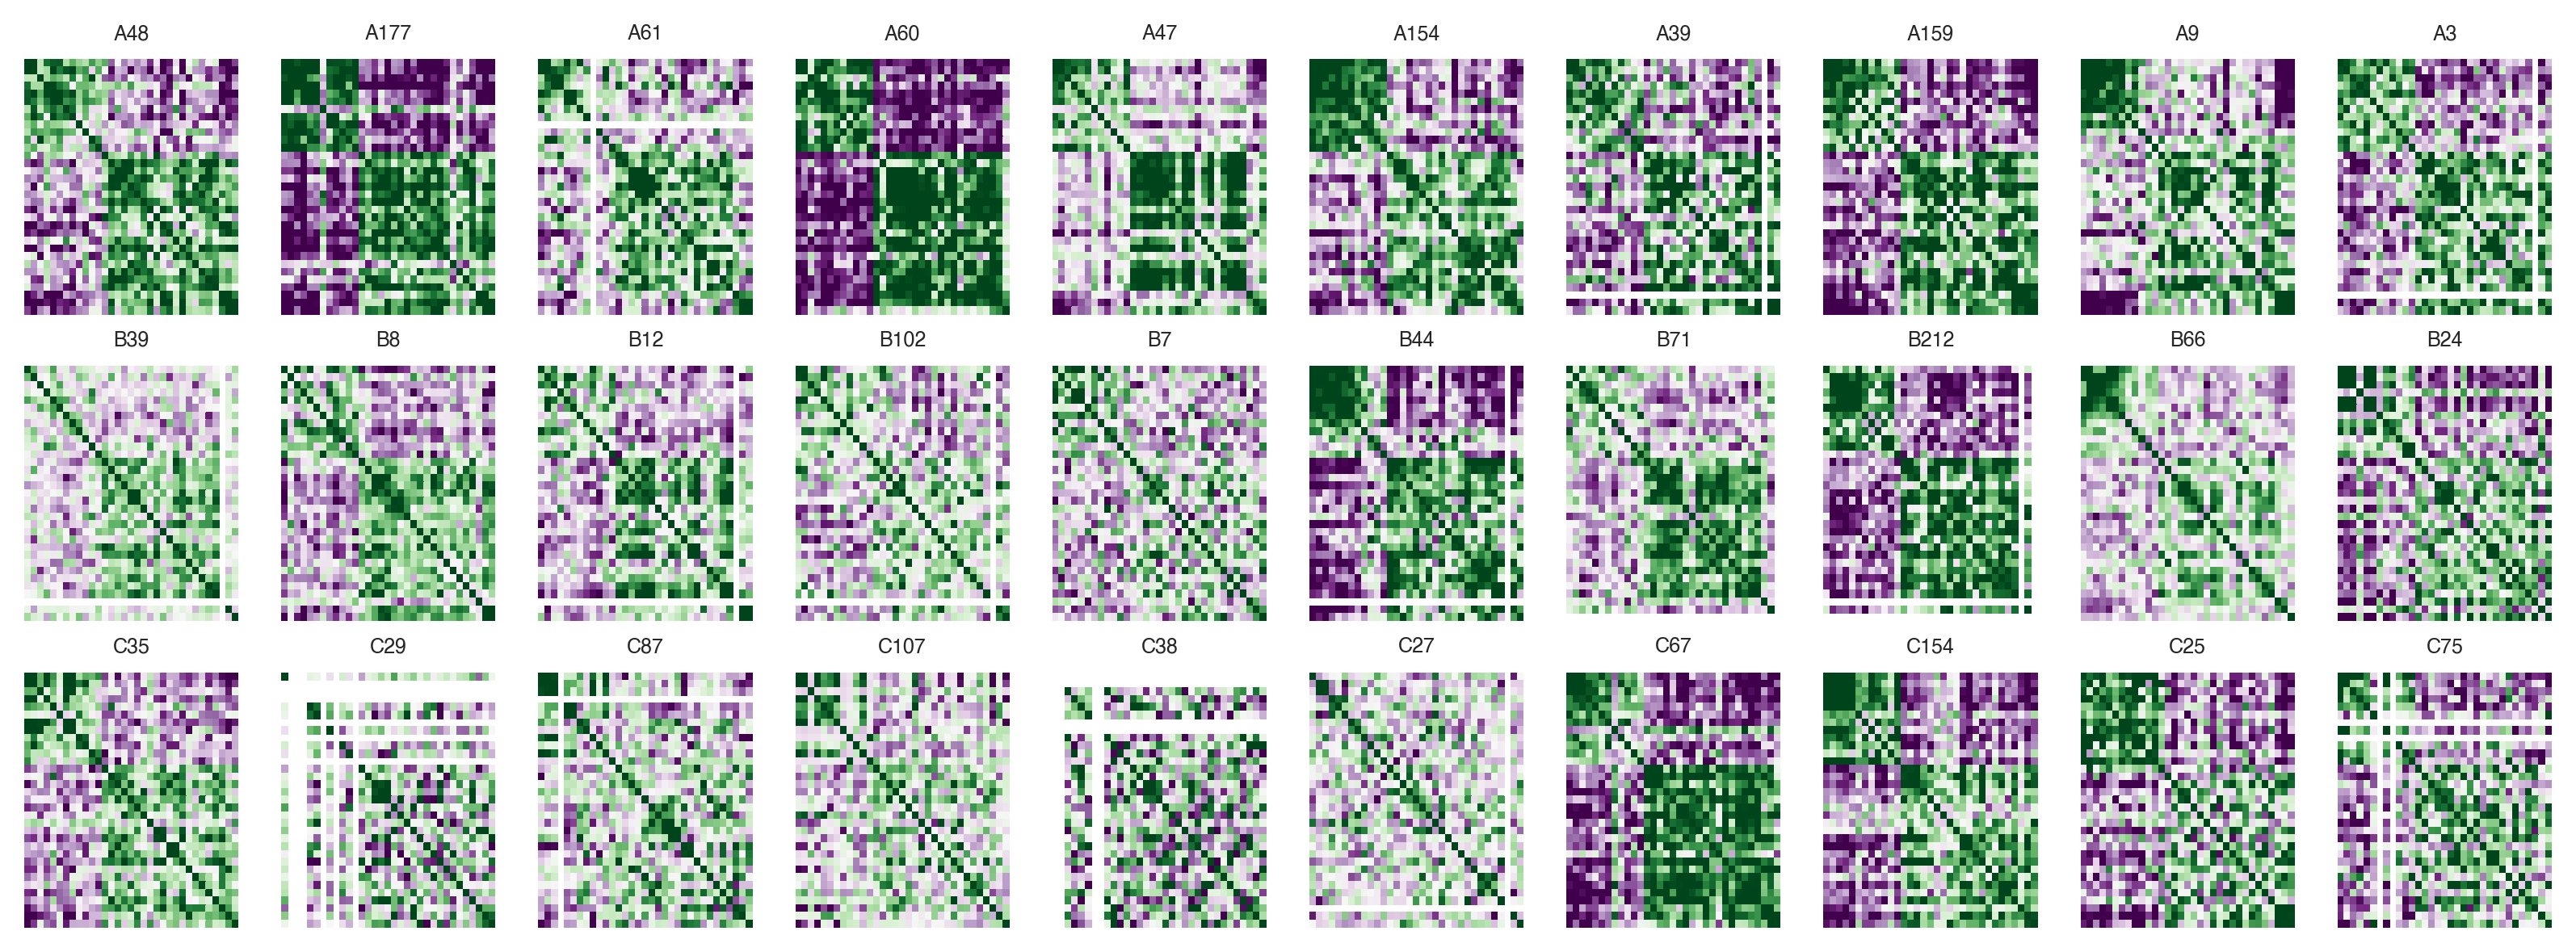

In [55]:
figsize=(270*mm, 100*mm)
fig,ax = plt.subplots(3,10,figsize=figsize, dpi=300)


for i,ds in enumerate(datasets[:3]):
    for j,cl in enumerate(ads[ds].obs.clone_id.unique()):
        EM = ads[ds][ads[ds].obs[ads[ds].obs.clone_id == cl].index, genes_ct].to_df()
        corr_mat = EM.corr()
        sns.heatmap(corr_mat, vmin=-0.5, vmax=0.5, cmap='PRGn',
                    cbar=False, cbar_kws={"shrink": .25}, xticklabels=False, yticklabels=False,
                   ax=ax[i,j])

        ax[i,j].set_ylabel('')
        ax[i,j].set_xlabel('')
        ax[i,j].set_title(cl)
set_size(fig, figsize)
plt.savefig('Panels/Celltype_corr_by_clone.pdf', bbox_inches='tight')
plt.show()

In [56]:
ads_all = [clone for ds in datasets for clone in ads[ds].obs.clone_id.unique()]
cells_all = [cell for ds in datasets for cell in ads[ds].obs_names]
print(ads_all)
print(len(cells_all))

['A48', 'A177', 'A61', 'A60', 'A47', 'A154', 'A39', 'A159', 'A9', 'A3', 'B39', 'B8', 'B12', 'B102', 'B7', 'B44', 'B71', 'B212', 'B66', 'B24', 'C35', 'C29', 'C87', 'C107', 'C38', 'C27', 'C67', 'C154', 'C25', 'C75']
660


In [57]:
plot_data = all_data[cells_all, :]
clone_CTs = plot_data.obs.groupby('clone_id').CT.mean().sort_values()
MEM_clones = list((clone_CTs[clone_CTs < 0]).index)
EFF_clones = list((clone_CTs[clone_CTs > 0]).index)
MEM_clones.sort()
EFF_clones.sort()
print(MEM_clones)
print(EFF_clones)
cells_all = [cell for clone in MEM_clones + EFF_clones for cell in plot_data.obs[plot_data.obs.clone_id == clone].index]
plot_data = plot_data[cells_all, :]

['A154', 'A159', 'A47', 'A48', 'A61', 'A9', 'C107', 'C154', 'C25', 'C29', 'C35', 'C38', 'C67', 'C75', 'C87']
['A177', 'A3', 'A39', 'A60', 'B102', 'B12', 'B212', 'B24', 'B39', 'B44', 'B66', 'B7', 'B71', 'B8', 'C27']


In [58]:
all_clonetype = pd.CategoricalDtype(categories=MEM_clones + EFF_clones, ordered=True) 
plot_data.obs.clone_id = plot_data.obs.clone_id.astype(all_clonetype)
plot_data.obs.clone_id.sort_values()

Trying to set attribute `.obs` of view, copying.


obs_names
P20407_A6_D180_p2_E22    A154
P20407_A6_D180_p1_G14    A154
P20407_A6_D180_p2_A14    A154
P20407_A6_D180_p2_J15    A154
P20407_A6_D180_p2_D15    A154
                         ... 
JHDex_387                 C27
JHDex_1030                C27
JHDex_1022                C27
JHDex_897                 C27
JHDex_676                 C27
Name: clone_id, Length: 660, dtype: category
Categories (30, object): ['A154' < 'A159' < 'A47' < 'A48' ... 'B7' < 'B71' < 'B8' < 'C27']

In [60]:
cellsort = plot_data.obs.sort_values(by=['clone_id','CT']).index
plot_data = plot_data[cellsort,:]
plot_data.obs

Donor    DonorDay  Timepoint batch clone_id  is_clone0  \
obs_names                                                                       
P20407_A6_D180_p1_A23  A1_06  A1_06_D180        180     6     A154          0   
P20407_A6_D180_p1_P2   A1_06  A1_06_D180        180     6     A154          0   
P20407_A6_D180_p5_K2   A1_06  A1_06_D180        180    10     A154          0   
P20407_A6_D180_p2_D15  A1_06  A1_06_D180        180     7     A154          0   
P20407_A6_D180_p4_E14  A1_06  A1_06_D180        180     9     A154          0   
...                      ...         ...        ...   ...      ...        ...   
JHDex_869                 JH    JH_D2000       2000    24      C27          0   
JHDex_897                 JH    JH_D2000       2000    24      C27          0   
JHDex_1375                JH    JH_D2000       2000    25      C27          0   
JHDex_257                 JH    JH_D2000       2000    22      C27          0   
JHDex_1113                JH    JH_D2000       2000    24      C27          0   

                       log1p_n_genes_by_counts  log1p_total_counts  \
obs_names                                                            
P20407_A6_D180_p1_A23                 7.362011            9.190626   
P20407_A6_D180_p1_P2                  7.461640            9.269087   
P20407_A6_D180_p5_K2                  7.780303            9.516579   
P20407_A6_D180_p2_D15                 7.886833            9.599240   
P20407_A6_D180_p4_E14                 7.873978            9.587313   
...                                        ...                 ...   
JHDex_869                             7.573017            9.326636   
JHDex_897                             7.463937            9.248785   
JHDex_1375                            7.660585            9.376258   
JHDex_257                             7.362645            9.115804   
JHDex_1113                            7.543273            9.304327   

                       log1p_total_counts_mt      n_counts  n_genes  \
obs_names                                                             
P20407_A6_D180_p1_A23               4.770802   9803.791992     1574   
P20407_A6_D180_p1_P2                4.817503  10604.062500     1739   
P20407_A6_D180_p5_K2                4.955447  13582.056641     2392   
P20407_A6_D180_p2_D15               4.789548  14752.574219     2661   
P20407_A6_D180_p4_E14               4.948664  14577.638672     2627   
...                                      ...           ...      ...   
JHDex_869                           4.544489  11232.286133     1944   
JHDex_897                           4.699993  10390.935547     1743   
JHDex_1375                          4.764137  11803.751953     2122   
JHDex_257                           4.498612   9096.940430     1575   
JHDex_1113                          4.681699  10984.447266     1887   

                       n_genes_by_counts              obs_names  \
obs_names                                                         
P20407_A6_D180_p1_A23               1574  P20407_A6_D180_p1_A23   
P20407_A6_D180_p1_P2                1739   P20407_A6_D180_p1_P2   
P20407_A6_D180_p5_K2                2392   P20407_A6_D180_p5_K2   
P20407_A6_D180_p2_D15               2661  P20407_A6_D180_p2_D15   
P20407_A6_D180_p4_E14               2627  P20407_A6_D180_p4_E14   
...                                  ...                    ...   
JHDex_869                           1944              JHDex_869   
JHDex_897                           1743              JHDex_897   
JHDex_1375                          2122             JHDex_1375   
JHDex_257                           1575              JHDex_257   
JHDex_1113                          1887             JHDex_1113   

                       pct_counts_mt  total_counts  total_counts_mt        CT  
obs_names                                                                      
P20407_A6_D180_p1_A23       1.193556   9803.791992       117.013771 -0.241531  
P20407_A6_D180_p1_P2  

Here we sort our genes in a "marker gene" fashion.

In [61]:
genes_nct = plot_data.to_df()[genes_nct].groupby(plot_data.obs.clone_id).mean().idxmax().astype(all_clonetype).sort_values().index

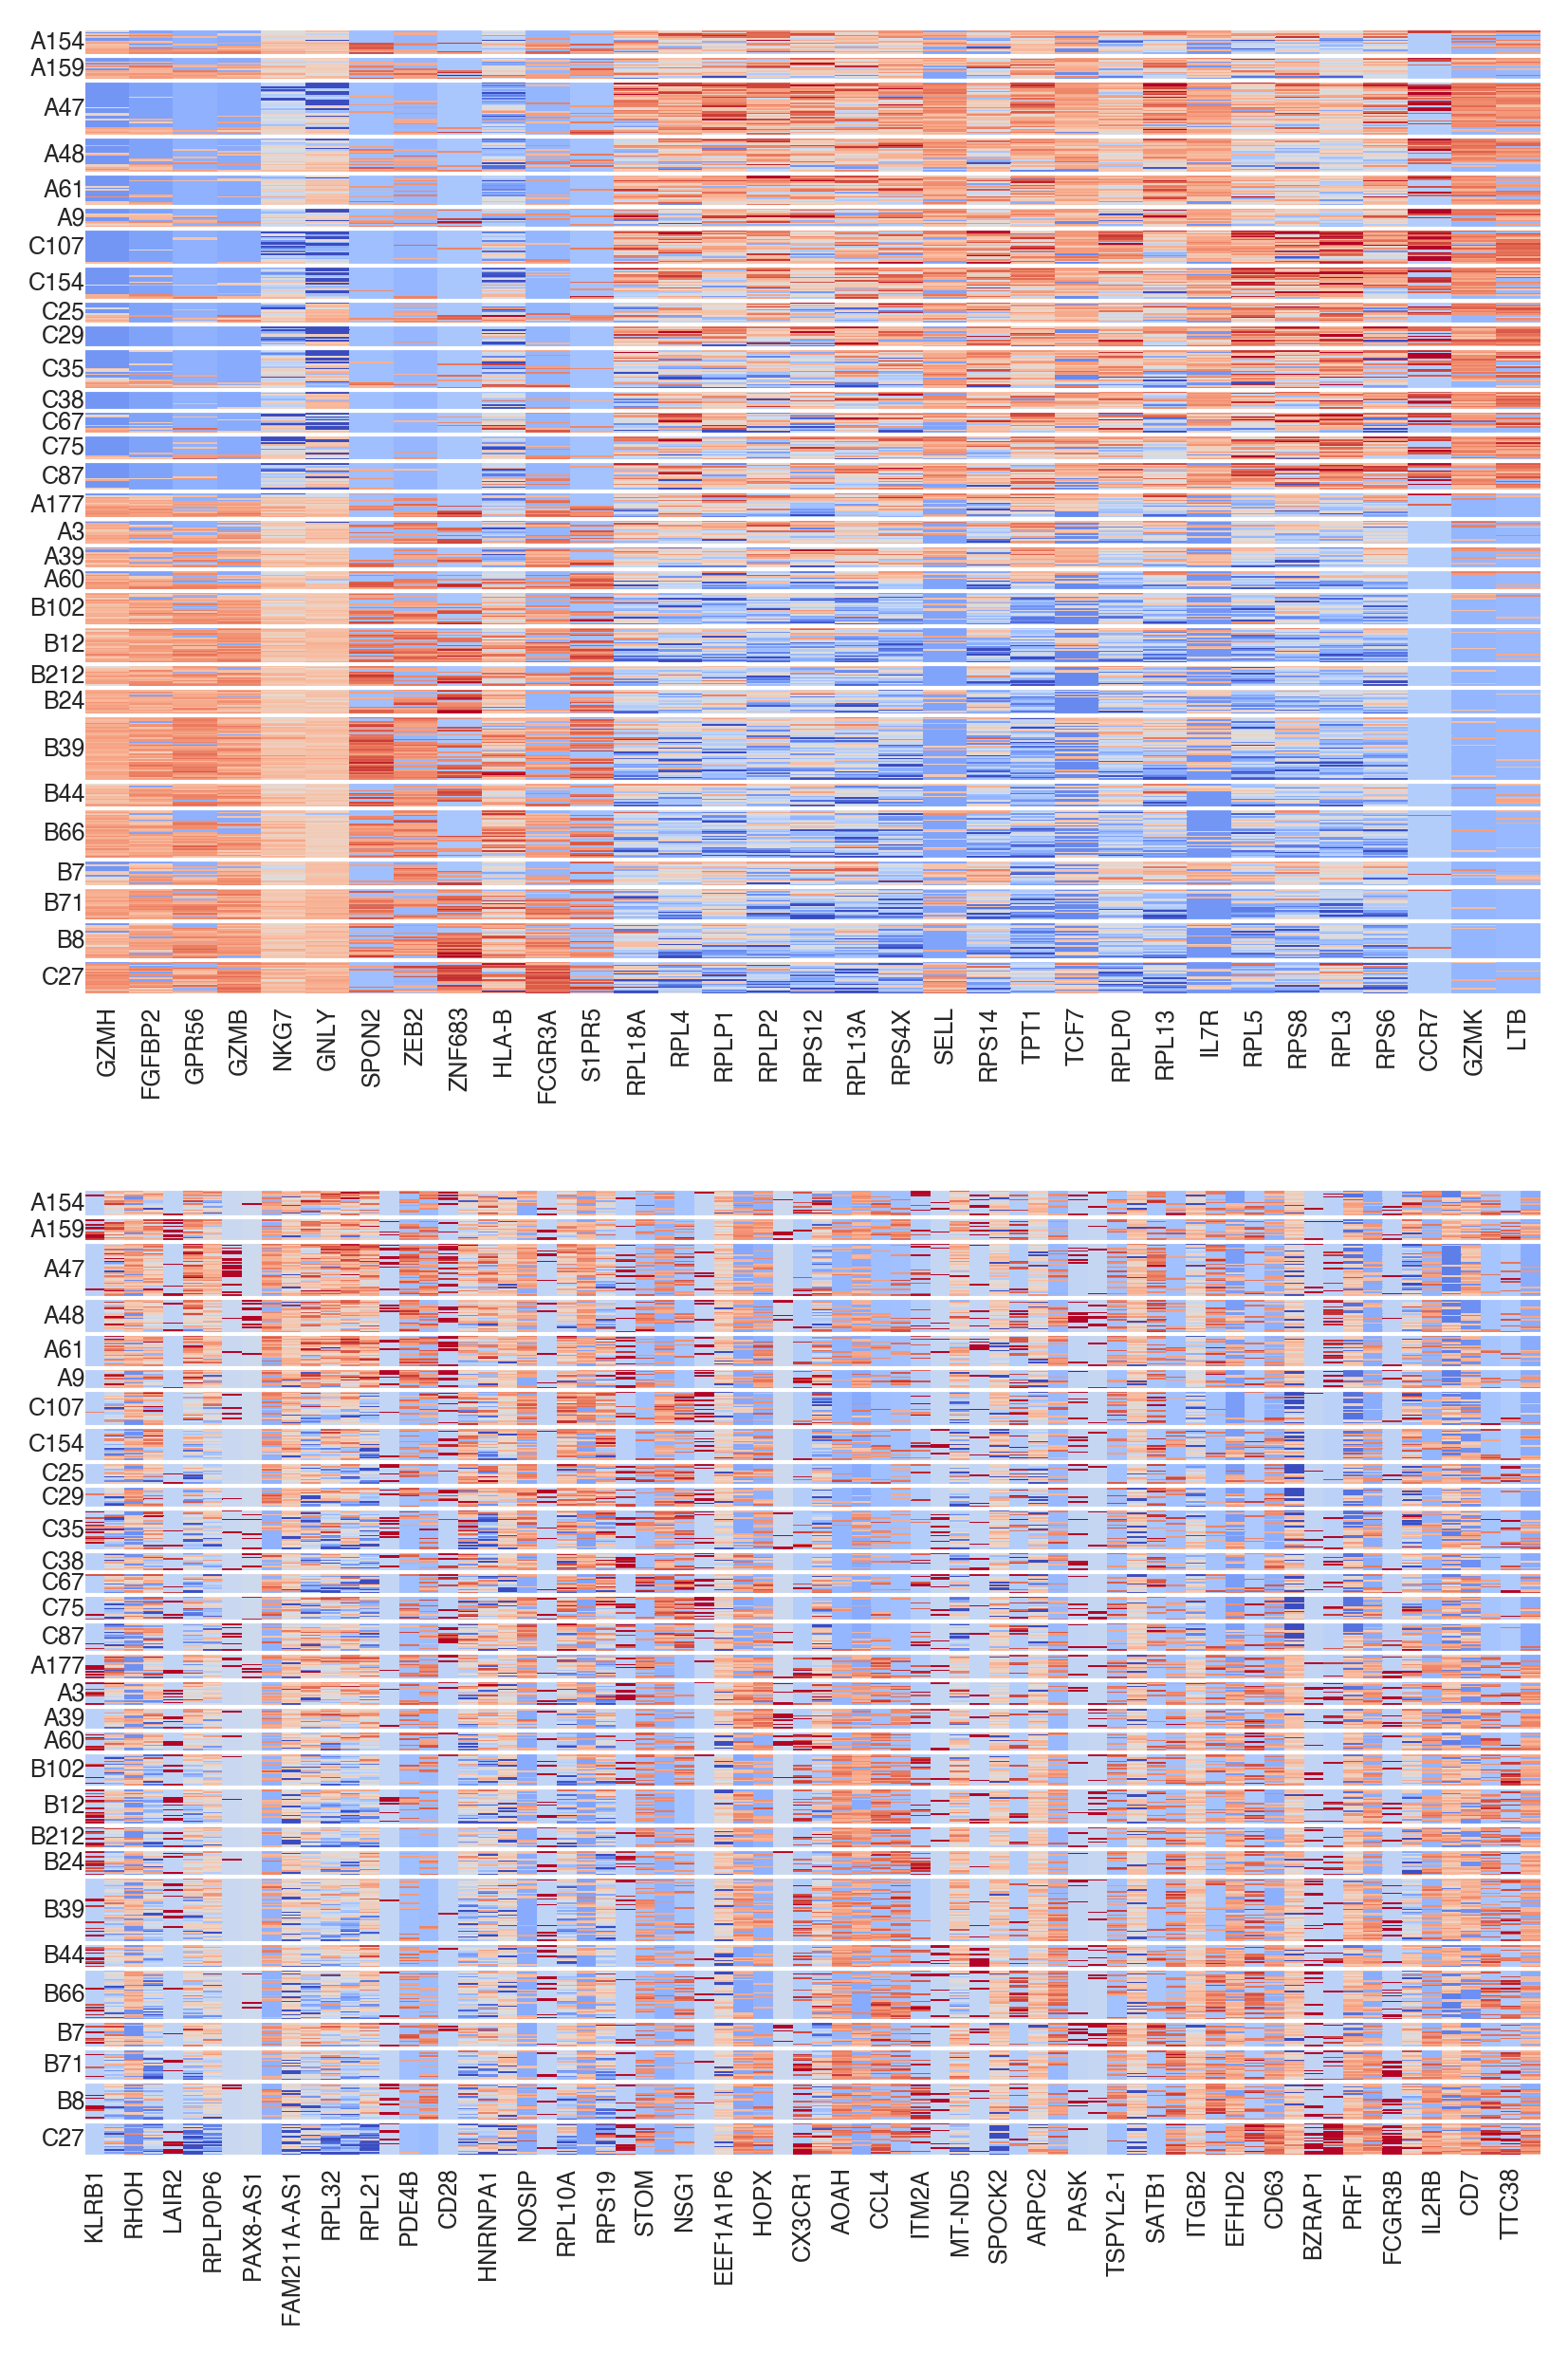

In [62]:
figsize=(140*mm, 210*mm)
fig,ax = plt.subplots(2,1, figsize=figsize, dpi=300, sharey=True)
sns.set_style('white')
setfontsize()
plot_df = plot_data.to_df()# .groupby(plot_data.obs.clone_id).mean()

#plot_df = plot_data.to_df().copy()
plot_df = (plot_df - plot_df.mean()) / plot_df.std()

sns.heatmap(plot_df[genes_ct], ax=ax[0], cbar=False, vmin=-2, vmax=2, cmap='coolwarm')

sns.heatmap(plot_df[genes_nct], ax=ax[1], cbar=False, vmin=-2, vmax=2, cmap='coolwarm')

curr_clone = ''
clone_list = list(all_data.obs.loc[plot_df.index].clone_id)
clone_list += ['']
old_j = 0
for j in range(len(plot_df) + 1):
    if clone_list[j] != curr_clone:
        ax[0].axhline(j, linewidth = 1, color='white')
        ax[1].axhline(j, linewidth = 1, color='white')
        if j > 0:
            ax[0].text( 0, (j+old_j)*0.5, curr_clone, ha='right', va='center')
            ax[1].text( 0, (j+old_j)*0.5, curr_clone, ha='right', va='center')
        curr_clone = clone_list[j]
        old_j = j
        
ax[0].set_yticks([])
ax[0].set_ylabel('')
ax[0].set_xlabel('')
ax[1].set_xlabel('')
ax[1].set_ylabel('')

ax[0].tick_params(axis='x', pad=-1)
ax[1].tick_params(axis='x', pad=-1)
set_size(fig, figsize)
plt.savefig('Panels/Heatmap_Invivo_SingleCell.pdf', bbox_inches='tight')
plt.show()

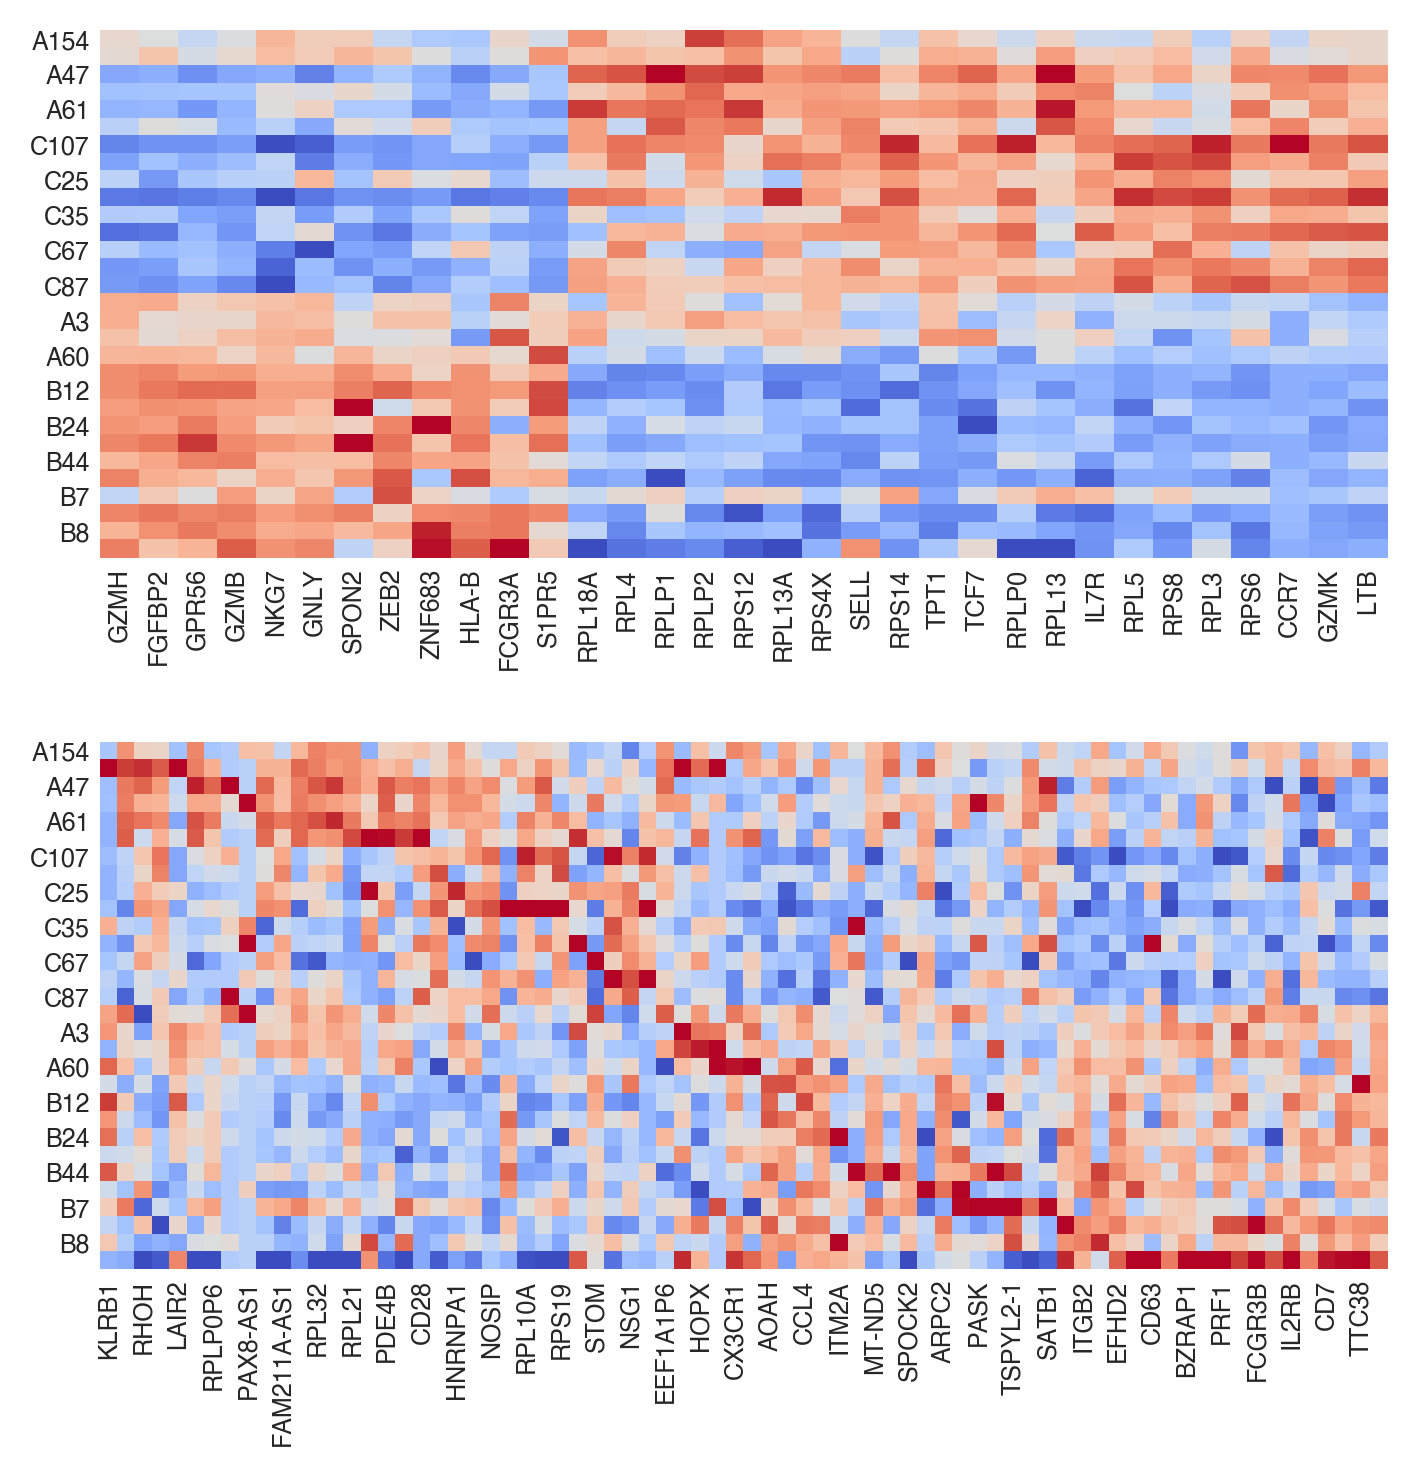

In [63]:
figsize=(120*mm, 125*mm)
fig,ax = plt.subplots(2,1,figsize=figsize, dpi=300, sharey=True,
                     gridspec_kw = {'wspace':0.35, 'hspace':0.35})

sns.set_style('white')
setfontsize()

plot_df = plot_data.to_df().groupby(plot_data.obs.clone_id).mean()

#plot_df = plot_data.to_df().copy()
plot_df = (plot_df - plot_df.mean()) / plot_df.std()

sns.heatmap(plot_df[genes_ct], ax=ax[0], cbar=False, vmin=-2, vmax=2, cmap='coolwarm')

sns.heatmap(plot_df[genes_nct], ax=ax[1], cbar=False, vmin=-2, vmax=2, cmap='coolwarm')

        
#ax[0].set_yticks(['A154','C27','A47','B71','B7','C112'])
ax[0].set_ylabel('')
ax[0].set_xlabel('')
ax[1].set_xlabel('')
ax[1].set_ylabel('')
#ax[0].set_xticklabels([])

ax[0].tick_params(axis='both', pad=-1)
ax[1].tick_params(axis='both', pad=-1)

set_size(fig, figsize)
plt.savefig('Panels/Heatmap_Invivo.pdf', bbox_inches='tight')
plt.show()


Abbreviating TSPYL2-1 as TSPYL2


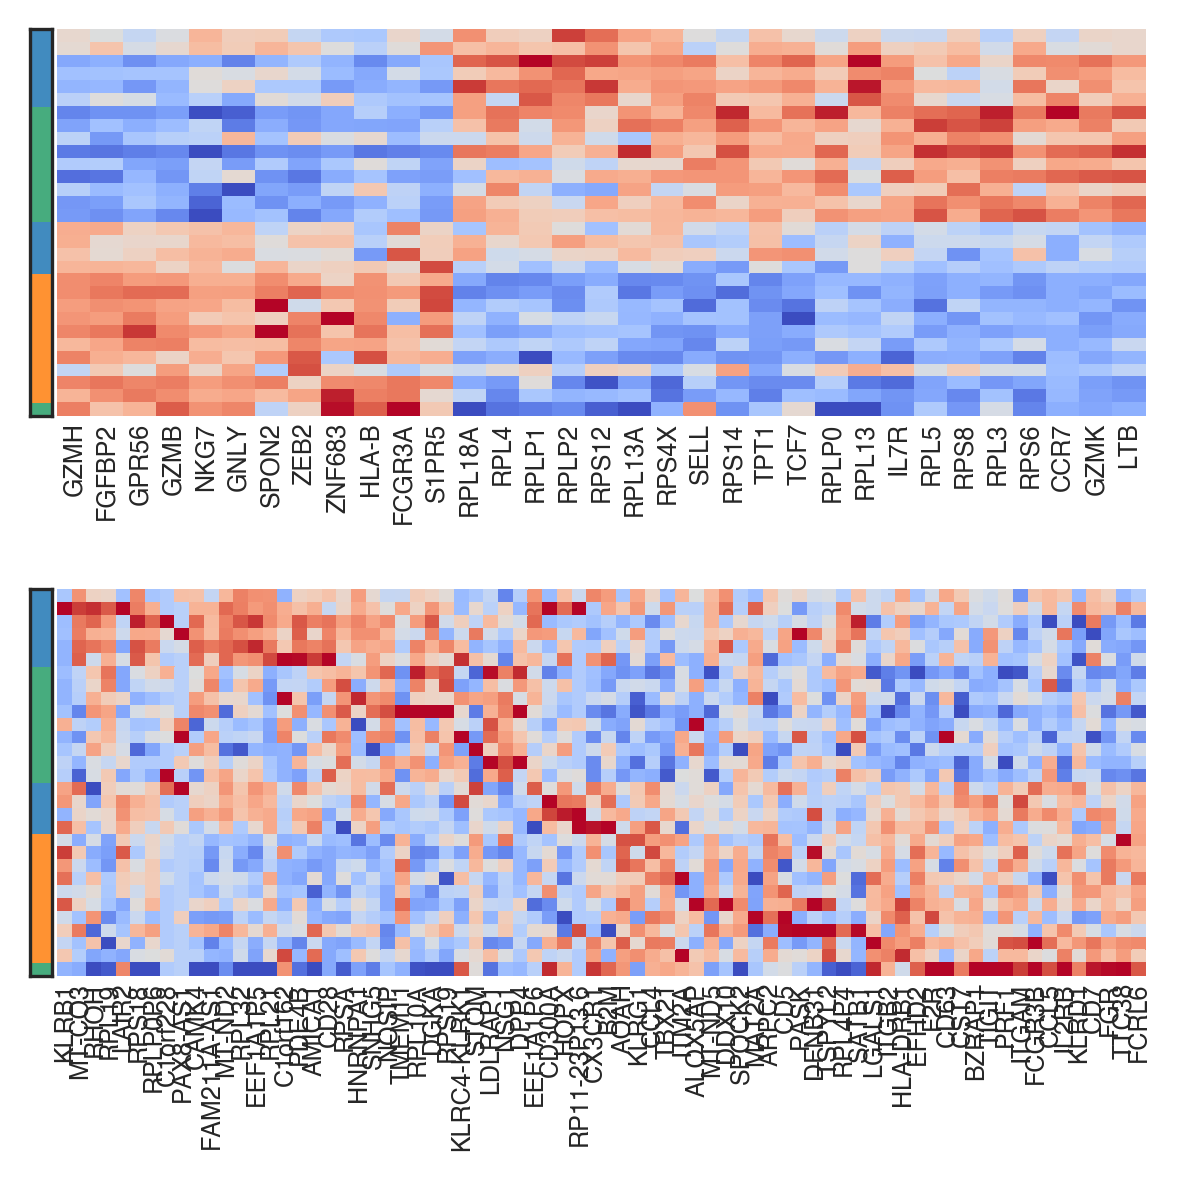

In [64]:
figsize=(100*mm, 100*mm)
fig,ax = plt.subplots(2,2,figsize=figsize, dpi=300, sharey=True,
                     gridspec_kw = {'wspace':0.01, 'hspace':0.45, 'width_ratios':[1,50]})

sns.set_style('white')
setfontsize()

plot_df = plot_data.to_df().groupby(plot_data.obs.clone_id).mean()

#plot_df = plot_data.to_df().copy()
plot_df = (plot_df - plot_df.mean()) / plot_df.std()

sns.heatmap(plot_df[genes_ct], ax=ax[0,1], cbar=False, vmin=-2, vmax=2, cmap='coolwarm', xticklabels=True)

sns.heatmap(plot_df[genes_nct], ax=ax[1,1], cbar=False, vmin=-2, vmax=2, cmap='coolwarm', xticklabels=True)

        
#ax[0].set_yticks(['A154','C27','A47','B71','B7','C112'])
for i in range(2):
    ax[i,1].set_yticks([])
    ax[i,0].set_xticks([])
    gts = ax[i,1].get_xticklabels()
    gts = [t.get_text() for t in gts]
    for j in range(len(gts)):
        gene = gts[j]
        if gene[-2:] == '-1':
            gts[j] = gene[:-2]
            print('Abbreviating {} as {}'.format(gene, gts[j]))
    ax[i,1].set_xticklabels(gts)
    for j in range(2):
        ax[i,j].set_xlabel('')
        ax[i,j].set_ylabel('')

pal = sns.color_palette()
lut = dict(zip(['A','B','C'], pal))
#colors = pd.Series(plot_df.index).map(lut)
#colors.name = 'Donor'
for j,cell in enumerate(plot_df[genes_ct].index):
    ax[0,0].add_patch(plt.Rectangle((0,j), 1, 1, color=lut[cell[0]], alpha=0.85, linewidth=0))
    ax[1,0].add_patch(plt.Rectangle((0,j), 1, 1, color=lut[cell[0]], alpha=0.85, linewidth=0))
    
ax[0,1].tick_params(axis='both', pad=-2)
ax[1,1].tick_params(axis='both', pad=-2)

set_size(fig, figsize)
plt.savefig('Panels/Heatmap_Invivo.pdf', bbox_inches='tight')
plt.show()

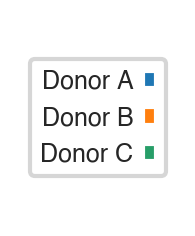

In [65]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements = [Patch(facecolor=lut[donor], edgecolor=None, label='Donor {}'.format(donor)) 
                   for donor in ['A','B','C']]

# Create the figure
figsize = (8*mm, 20*mm)
fig, ax = plt.subplots(1,1,figsize=figsize, dpi=300)
sns.set_style('white')
setfontsize()
ax.legend(handles=legend_elements, loc='center', markerfirst=False)
ax.set_frame_on(False)
ax.set_xticks([])
ax.set_yticks([])

set_size(fig, figsize)
plt.savefig('Panels/Heatmap_donorleg.pdf', bbox_inches='tight')
    
plt.show()

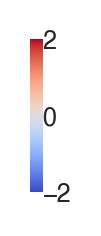

In [66]:
import matplotlib as mpl

figsize = (8*mm, 20*mm)
fig, ax = plt.subplots(1,1,figsize=figsize, dpi=300)
sns.set_style('white')
setfontsize()

cmap = mpl.cm.coolwarm
norm = mpl.colors.Normalize(vmin=-2, vmax=2)

cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                  cax=ax, orientation='vertical')

#[s.set_visible(False) for s in ax.spines.values()]
cb.outline.set_visible(False)
ax.tick_params(axis='y', pad=0, length=0)

set_size(fig, figsize)
plt.savefig('Panels/Heatmap_colorbar.pdf', bbox_inches='tight')
    
plt.show()

In [67]:
invivo_gene_df = pd.DataFrame(index = list(genes_ct) + list(genes_nct))
invivo_gene_df['celltype'] = invivo_gene_df.index.isin(genes_ct)
invivo_gene_df


celltype
GZMH        True
FGFBP2      True
GPR56       True
GZMB        True
NKG7        True
...          ...
KLRD1      False
CD7        False
FGR        False
TTC38      False
FCRL6      False

[107 rows x 1 columns]

In [68]:
invivo_gene_df.to_csv('Invivo_genes.csv')

... storing 'Donor' as categorical
... storing 'DonorDay' as categorical
... storing 'batch' as categorical
... storing 'clone_id' as categorical
... storing 'bigclone' as categorical


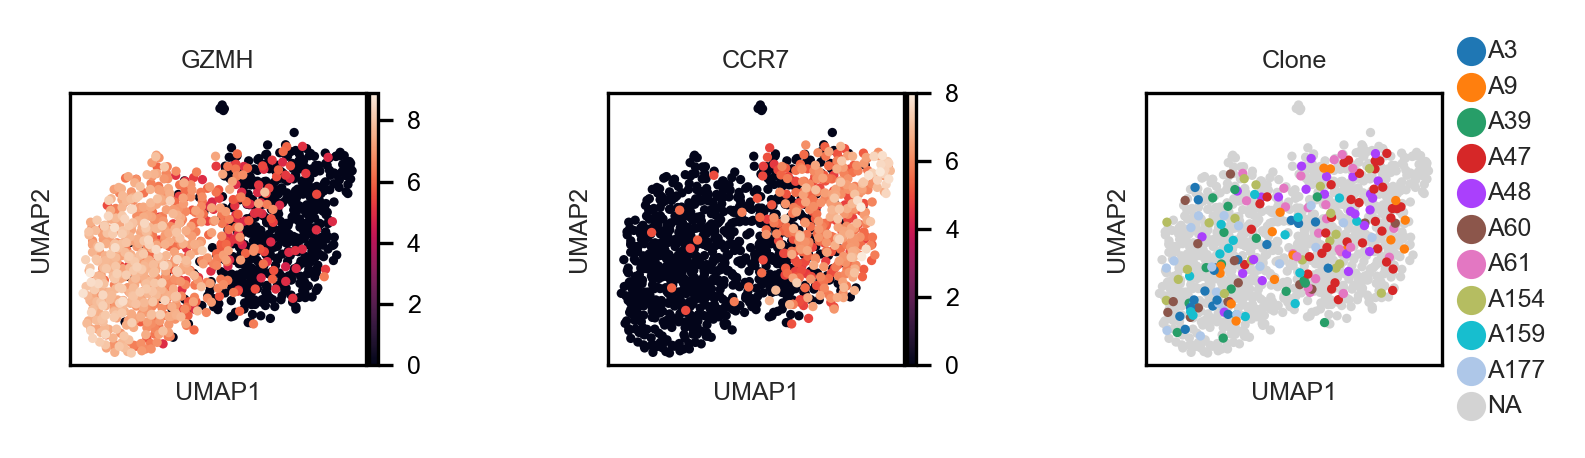

... storing 'Donor' as categorical
... storing 'DonorDay' as categorical
... storing 'batch' as categorical
... storing 'clone_id' as categorical
... storing 'bigclone' as categorical


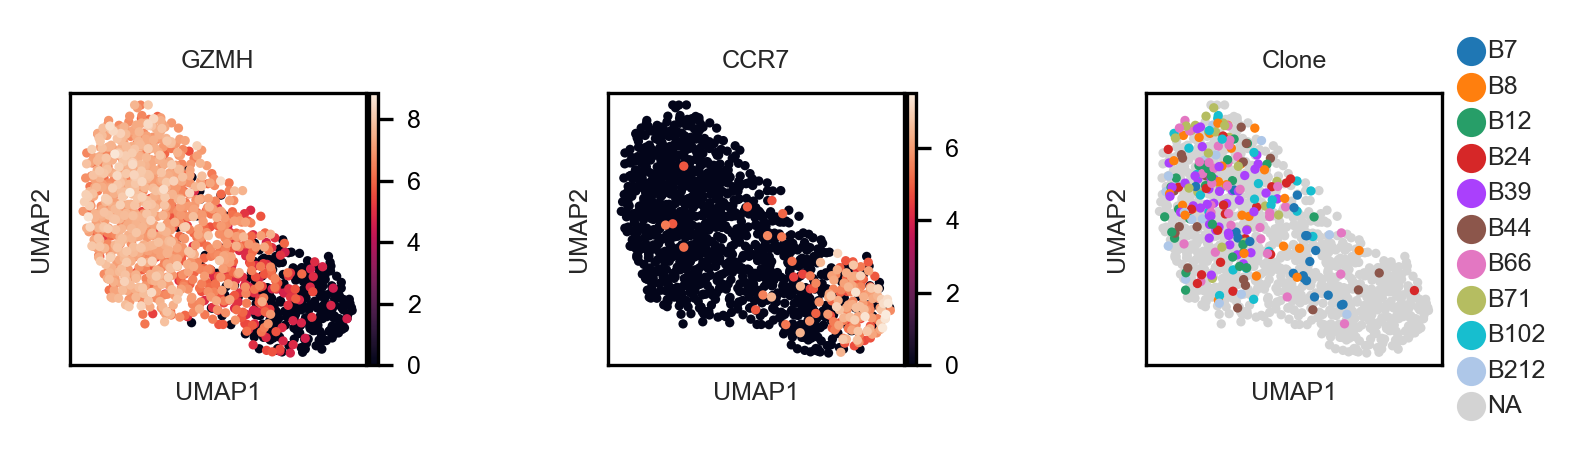

... storing 'Donor' as categorical
... storing 'DonorDay' as categorical
... storing 'batch' as categorical
... storing 'clone_id' as categorical
... storing 'bigclone' as categorical


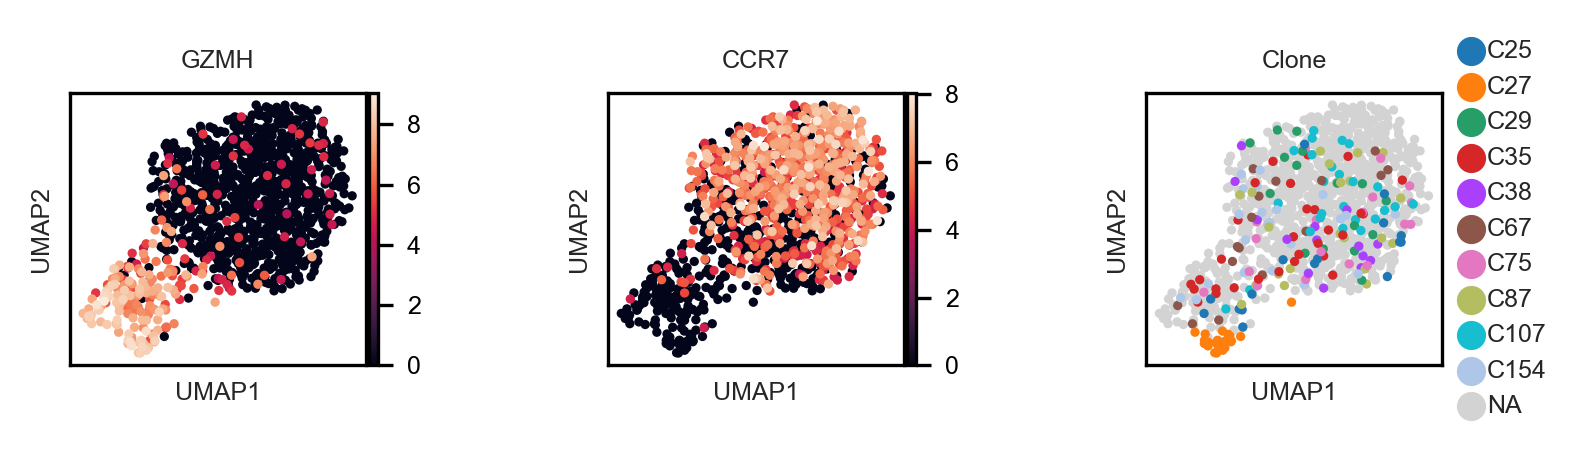

In [69]:
mm = 1/25.4

sc.set_figure_params(scanpy=True, dpi=300, dpi_save=300, frameon=True, vector_friendly=True, 
                     fontsize=6, figsize=(30*mm, 30*mm), color_map=None, format='pdf', 
                     facecolor=None, transparent=False, ipython_format='png2x')

ad_t = {}
for ds in datasets:
    ad_t[ds] = adata[ds][:,sig_all].copy()
    ad_t[ds].obs['bigclone'] = ad_t[ds].obs['clone_id'].mask(~ad_t[ds].obs['clone_id'].isin(bigclones[ds]))
    sc.tl.pca(ad_t[ds], svd_solver='arpack', use_highly_variable=False)
    sc.pp.neighbors(ad_t[ds], n_neighbors=10, n_pcs=40, key_added='cloud')
    #sc.tl.paga(ad_t[ds])
    #sc.pl.paga(ad_t[ds], plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
    sc.tl.umap(ad_t[ds], neighbors_key='cloud')
    sc.pl.umap(ad_t[ds], color=['GZMH', 'CCR7', 'bigclone'], legend_fontsize=6, size=20,
              title=['GZMH', 'CCR7', 'Clone'], save='UMAP_cloud_{}.png'.format(ds))
    #sc.pl.umap(ad_t[ds], color=['GZMH', 'CCR7', 'GNLY'], legend_fontsize=6, size=20,
    #          title=['Clone ID'], save='UMAP_clone_cloud_{}.png'.format(ds))
    plt.show()

Now we make some dataframes for finding clonal genes, just using these big clones.

In [70]:
from matplotlib.colors import ListedColormap

def cloud_plot(ad, ds_title):
    
    figsize=(90*mm, 40*mm)
    fig,ax = plt.subplots(1,2,figsize=figsize, dpi=300, sharex=True, sharey=True)
    
    # Black-Red colormap
    N = 256
    vals = np.ones((N, 4))
    vals[:, 0] = np.linspace(0, 1, N)
    vals[:, 1] = np.linspace(0, 0.4, N)
    vals[:, 2] = np.linspace(0, 0.4, N)
    vals[:, 3] = np.linspace(0,1,N)
    redmap = ListedColormap(vals)
    
    vals = np.ones((N, 4))
    vals[:, 0] = np.linspace(0, 0.4, N)
    vals[:, 1] = np.linspace(0, 0.4, N)
    vals[:, 2] = np.linspace(0, 1, N)
    vals[:, 3] = np.linspace(0,1,N)
    bluemap = ListedColormap(vals)
    
    plot_df = pd.DataFrame(index=ad.to_df().index)
    plot_df['GZMH'] = ad.to_df()['GZMH']
    plot_df['CCR7'] = ad.to_df()['CCR7']
    plot_df['UMAP1'] = ad.obsm['X_umap'][:,0]
    plot_df['UMAP2'] = ad.obsm['X_umap'][:,1]
    plot_df['Clone'] = ad.obs['bigclone']
    if plot_df.sort_values(by='CCR7')['UMAP1'][:10].mean() < plot_df['UMAP1'].mean():
        plot_df['UMAP1'] = -1*plot_df['UMAP1'] # Put high CCR7 on the left.
    
    
    sns.scatterplot(x='UMAP1', y='UMAP2', hue='GZMH', data=plot_df, s=6, edgecolor=None, palette=redmap,
                    ax=ax[0],  legend=False)
    sns.scatterplot(x='UMAP1', y='UMAP2', hue='CCR7', data=plot_df, s=6, edgecolor=None, palette=bluemap,
                    ax=ax[0], legend=False)
    
    sns.scatterplot(x='UMAP1', y='UMAP2', color='lightgray', data=plot_df, edgecolor=None, alpha=1, ax=ax[1], s=6)
    sns.scatterplot(x='UMAP1', y='UMAP2', hue='Clone', data=plot_df, edgecolor='k', alpha=1, ax=ax[1], s=7)
    ax[1].legend(bbox_to_anchor = (1.0,1.05), frameon=False)
    ax[0].tick_params(axis='both', pad=-1)
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[0].set_title('CCR7 vs GZMH', y=0.95)
    ax[1].set_title('10 Biggest clones', y=0.95)
    set_size(fig, figsize)
    plt.savefig('Panels/Cloud_{}.pdf'.format(ds_title), bbox_inches='tight')
    plt.show()


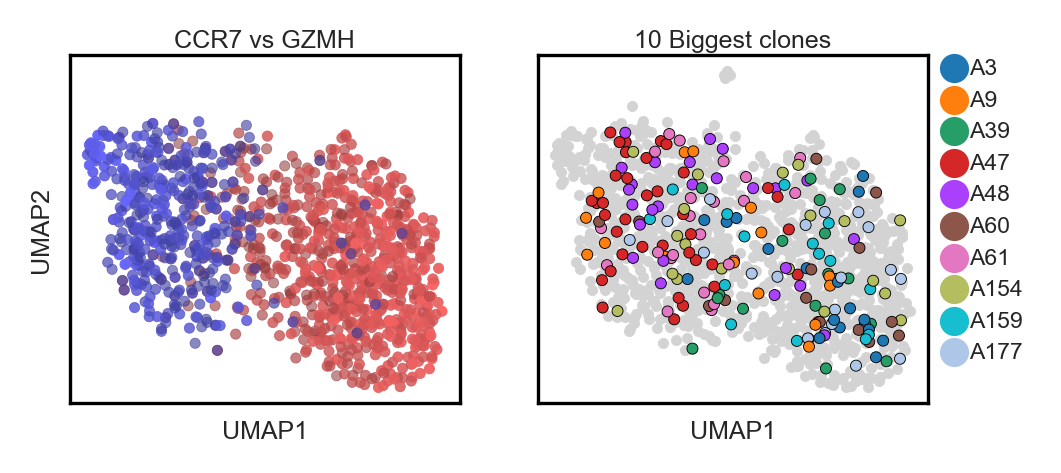

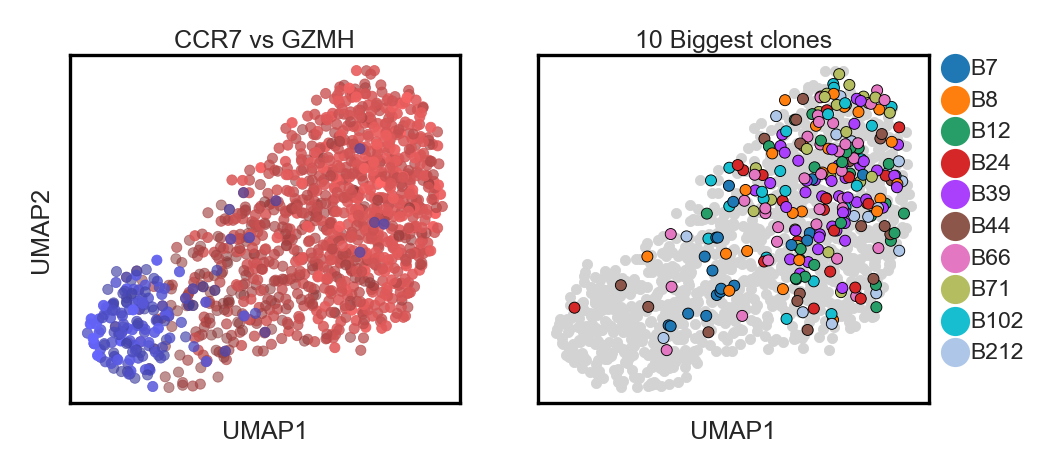

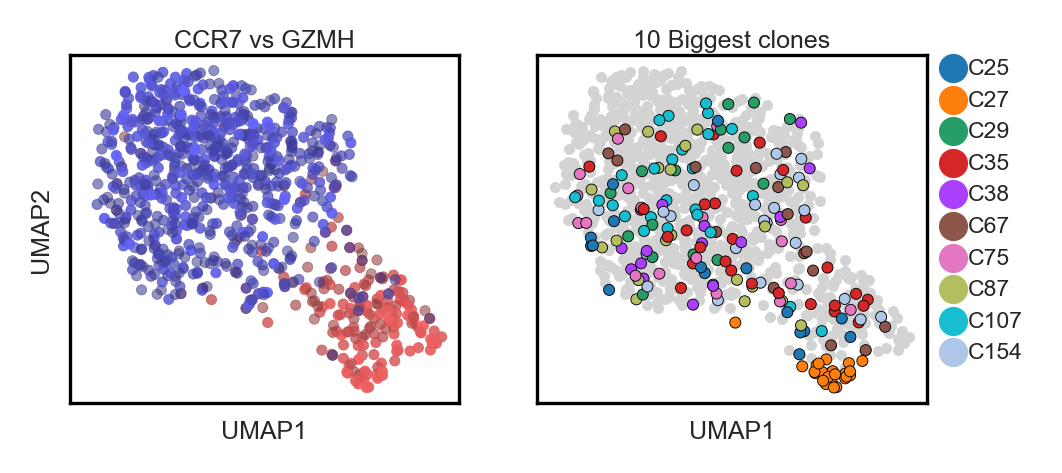

In [71]:
for ds in datasets:
    cloud_plot(ad_t[ds], ds)

In [112]:
ad_t[jh]

AnnData object with n_obs × n_vars = 1172 × 107
    obs: 'Donor', 'DonorDay', 'Timepoint', 'batch', 'clone_id', 'is_clone0', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'log1p_total_counts_mt', 'n_counts', 'n_genes', 'n_genes_by_counts', 'obs_names', 'pct_counts_mt', 'total_counts', 'total_counts_mt', 'CT', 'bigclone'
    var: 'GC_content', 'gene_name', 'highly_variable', 'highly_variable_rank', 'log1p_mean_counts', 'log1p_total_counts', 'mean_counts', 'means', 'mt', 'n_cells', 'n_cells_by_counts', 'n_counts', 'pct_dropout_by_counts', 'total_counts', 'transcript_length', 'variances', 'variances_norm'
    uns: 'pca', 'cloud', 'umap', 'bigclone_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'cloud_distances', 'cloud_connectivities'

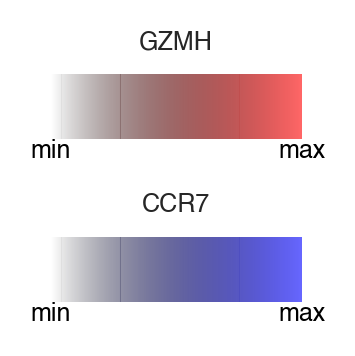

In [72]:
import matplotlib as mpl

figsize = (30*mm, 30*mm)
fig, ax = plt.subplots(2,1,figsize=figsize, dpi=300,
                      gridspec_kw={'hspace':1.5})
sns.set_style('white')
setfontsize()

# Black-Red colormap
N = 256
vals = np.ones((N, 4))
vals[:, 0] = np.linspace(0, 1, N)
vals[:, 1] = np.linspace(0, 0.4, N)
vals[:, 2] = np.linspace(0, 0.4, N)
vals[:, 3] = np.linspace(0,1,N)
redmap_trans = ListedColormap(vals)
    
vals = np.ones((N, 4))
vals[:, 0] = np.linspace(0, 0.4, N)
vals[:, 1] = np.linspace(0, 0.4, N)
vals[:, 2] = np.linspace(0, 1, N)
vals[:, 3] = np.linspace(0,1,N)
bluemap_trans = ListedColormap(vals)

cb = {}
cb[0] = fig.colorbar(mpl.cm.ScalarMappable(cmap=redmap_trans),
                  cax=ax[0], orientation='horizontal')

cb[1] = fig.colorbar(mpl.cm.ScalarMappable(cmap=bluemap_trans),
                  cax=ax[1], orientation='horizontal')

#[s.set_visible(False) for s in ax.spines.values()]
for j in range(2):
    cb[j].outline.set_visible(False)
    ax[j].tick_params(axis='x', pad=0, length=0)
    cb[j].set_ticks([0,0.5,1])
    cb[j].set_ticklabels(['min','','max'])

ax[0].set_title('GZMH')
ax[1].set_title('CCR7')

set_size(fig, figsize)
plt.savefig('Panels/Cloudmap_colorbar.pdf', bbox_inches='tight')
    
plt.show()

In [73]:
from matplotlib.colors import Normalize

In [74]:
def minivio(gene, ad, prop='clone_id', proporder=None, hide_clones = False, show_ons = False,
               clip = False, style='binary', filename=None):

    df = pd.DataFrame(ad.to_df()[gene].copy())
    df[prop] = ad.obs[prop]
    df['Celltype'] = ad.obs['CT']
    df_noclone = df.copy()
    df_noclone[prop] = 'All'
    #create a figure
    sns.set_style('whitegrid')
    setfontsize()
    figsize=(45*mm,30*mm)
    fig,ax = plt.subplots(1,2,figsize=figsize, dpi=300, sharey=True,
                         gridspec_kw={'width_ratios':[4,1],
                                     'wspace':0.05})
    
    ax[0].tick_params(axis='both', which='major', pad=-2)
    # ax.legend_.remove()
    
    if style == 'tune':
        genemean = df[gene].mean()
        genestd = df[gene].std()
        # Create the violin
        sns.violinplot(x=prop, y=gene, inner=None, scale='width', order=proporder, data=df, alpha=0.2, 
                       color='lightgray', linewidth=0.4, cut=0, ax=ax[0])
        #sns.swarmplot(x=prop, y=gene, order=proporder, data=df, size=0.75, ax=ax[0])
        sns.stripplot(x=prop, y=gene, order=proporder, data=df, size=1.25, ax=ax[0])
        ax[0].set_ylim((max(df[gene].min() - 0.25,0), df[gene].max() + 0.25))
        gene_range = df[gene].max() - df[gene].min()
    elif style == 'binary':
        
        maxes = df.groupby(prop).max()[gene]
        nonzeros = df.groupby(prop).apply(lambda x : (x > np.log1p(10)).sum() / len(x))[gene]
        if show_ons:
            for x,clone in enumerate(clones):
                nz_label = int(nonzeros[clone]*100)
                if nz_label > 0:
                    ax.text(x, maxes[clone]+0.2, '{}%'.format(nz_label), 
                            ha='center', rotation=75) # '.{:0>2}'.format(int(nonzeros[clone]*100)), ha='center')

        sns.violinplot(x=prop, y=gene, inner=None, scale='width', order=proporder, data=df,
                       alpha=0.15, linewidth=0.4, cut=0, ax=ax[0])
        for violin in ax[0].collections:
            violin.set_alpha(0.15)
        
        #Create a matplotlib colormap from the sns seagreen color palette
        cmap = sns.color_palette("RdYlBu_r", as_cmap=True )
        # Normalize to the range of possible values from df["c"]
        norm = Normalize(vmin=-0.5, vmax=0.5)
        # create a color dictionary (value in c : color from colormap) 
        colors = {}
        for cval in df[df[gene] > 0].Celltype:
            colors.update({cval : cmap(norm(cval))})
        
        #sns.swarmplot(x=prop, y=gene, order=proporder, data=df[df[gene] > 0], 
        #              hue='Celltype', size=0.75, ax=ax[0], palette=colors) #'RdYlBu_r')
                     #vmin=-0.5, vmax=0.5)
        sns.stripplot(x=prop, y=gene, order=proporder, data=df[df[gene] > 0], 
                      size=1.25, ax=ax[0], palette=colors) #'RdYlBu_r')
                     #vmin=-0.5, vmax=0.5)
        ax[0].get_legend().remove()
        gene_range = df[gene].max()
        ax[0].set_ylim((-0.15*gene_range, df[gene].max()*1.15))
    
    sns.violinplot(x=prop, y=gene, data=df_noclone, color='lightgray', width=1,
                   inner=None, saturation=0.8, linewidth=0.4, cut=0, ax=ax[1], legend=False)
    #sns.swarmplot(x=prop, y=gene, data=df_noclone, color='k', size=1.25, ax=ax[1])
    
    df_zeros = pd.DataFrame(df.groupby(prop).apply(lambda s : (s==0).sum() / len(s) ))
    #display(df_zeros)
    df_zeros.columns = ['Zero count',prop,'Celltype']
    df_zeros[prop] = df_zeros.index
    #df_zeros[prop] = df_zeros.index
    df_zeros['yo'] = 0
    sns.scatterplot(x=prop, y='yo', size='Zero count', hue=prop, sizes=(0,6), size_norm = (0,1), data=df_zeros, 
                    edgecolor='k', linewidth=0.25, ax=ax[0], legend=False)
    
    
    ct_df = pd.DataFrame(ad.obs.Celltype.groupby(ad.obs[prop]).mean())
    ct_df[prop] = ct_df.index
    #ct_df = ct_df.sort_values()
    ct_df['bott'] = -0.1*gene_range
    #sns.scatterplot(x=prop, y='bott', marker='D', s=3, sizes=(5,5), hue='Celltype', data=ct_df, 
    #                hue_norm = (-0.5, 0.5), palette='RdYlBu_r', ax=ax[0], legend=False)
    
    #for j,cl in enumerate(ct_df.index):
    #    ax[0].add_patch(Rectangle((j,0),1,-0.1, color=ct_df[cl], fill=True,clip_on=False))
    ax[0].set_xlabel('')
    ax[1].set_xlabel('')
    ax[0].set_ylabel('')
    ax[1].set_ylabel('')
    ax[0].tick_params(axis='both', which='major', pad=-1)
    
    ax[0].set_yticks([0,np.floor(df[gene].max()*0.6), np.floor(df[gene].max()*1.15)])
    if hide_clones:
        ax[0].set_xticks([])
        ax[1].set_xticks([])
    #ax.set_xlabel('Clone')
    #ax.set_ylabel('$log_2({})$.'.format(genename))
    
    title_lines = ['{}'.format(gene)]
    fig.suptitle('\n '.join(title_lines),y=1.05)
    if filename:
        set_size(fig, figsize)
        plt.savefig(filename, bbox_inches='tight')
    plt.show()

In [75]:
def zero_jitter(ser):
    out_ser = ser.copy()
    height = 0
    width = 5
    zero_count = 0
    for i in out_ser.index:
        if out_ser[i] < 0.1:
            zero_count += 1
            out_ser[i] += 0.3*height
        if zero_count > width:
            height += 1
            width -= 1
            zero_count = 0
    return out_ser

def gp_jitter(ser, gps):
    out_ser = ser.copy()
    for gp in gps.unique():
        out_ser[gps == gp] = zero_jitter(out_ser[gps == gp])
    return out_ser
    

In [76]:
def minivio(gene, gf, full_gf, mf, prop='clone_id', hide_clones = False, show_ons = False, gmax=10,
               proporder=None, clip = False, style='binary', filename=None):
    #if gn[:4] == 'ENSG':
    #    gene = gn
    #    genename = gene_names[gn]
    #else:
    #    gene = get_ensg(gn)
    #    genename = gn
    genename = gene   
    df = pd.DataFrame(gf[gene].copy())
    df[prop] = mf[prop]
    df[gene] = gp_jitter(df[gene], df[prop])
    
    df_noclone = pd.DataFrame(full_gf[gene].copy())
    df_noclone[prop] = 'All'
    #df_noclone = df.copy()
    #df_noclone[prop] = 'All'
    #create a figure
    sns.set_style('whitegrid')
    figsize=(50*mm,35*mm)
    fig,ax = plt.subplots(1,2,figsize=figsize, dpi=300, sharey=True,
                         gridspec_kw={'width_ratios':[5,1],
                                     'wspace':0.05})
    setfontsize()
    ax[0].tick_params(axis='both', which='major', pad=-2)
    # ax.legend_.remove()
    
    if style == 'tune':
        genemean = df[gene].mean()
        genestd = df[gene].std()
        #ax[0].axhline(y=genemean, color='k', linestyle='-', alpha=0.5, linewidth=0.25)
        #ax[0].axhline(y=genemean+genestd, color='gray', linestyle=':', linewidth=0.25)
        #ax[0].axhline(y=genemean-genestd, color='gray', linestyle=':', linewidth=0.25)
        # Create the violin
        sns.violinplot(x=prop, y=gene, inner=None, scale='width', order=proporder, data=df, alpha=0.2, 
                       color='white', linewidth=0.5, cut=0, ax=ax[0])
        sns.swarmplot(x=prop, y=gene, order=proporder, data=df, size=2, ax=ax[0])
        #ax[0].set_ylim((max(df[gene].min() - 0.25,0), df[gene].max() + 0.25))
        #ax[0].set_ylim((max(df[gene].quantile(0.05) - 0.25,0), df[gene].max() + 0.25))
        ax[0].set_ylim(-0.25, gmax)
    elif style == 'binary':
        
        maxes = df.groupby(prop).max()[gene]
        nonzeros = df.groupby(prop).apply(lambda x : (x > np.log1p(10)).sum() / len(x))[gene]
        if show_ons:
            for x,clone in enumerate(clones):
                nz_label = int(nonzeros[clone]*100)
                if nz_label > 0:
                    ax.text(x, maxes[clone]+0.2, '{}%'.format(nz_label), 
                            ha='center', rotation=75) # '.{:0>2}'.format(int(nonzeros[clone]*100)), ha='center')
        #plt.axhline(y=log2p(10), color='k', linestyle='-', alpha=0.5, linewidth=0.25)
        #sns.violinplot(x=prop, y=gene, inner='stick', scale='width', order=proporder, data=df, 
        #               color='gray', saturation=0.2, 
        #               linewidth=0.4, cut=0, ax=ax[0])
        sns.violinplot(x=prop, y=gene, inner=None, scale='width', order=proporder, data=df, alpha=0.1, 
                       color='white', linewidth=0.5, cut=0, ax=ax[0])
        sns.swarmplot(x=prop, y=gene, order=proporder, data=df, size=2, ax=ax[0])
        ax[0].set_ylim((-1, df[gene].max()*1.15))
    
    sns.violinplot(x=prop, y=gene, data=df_noclone, color='gray', width=1,
                   inner=None, saturation=0.8, linewidth=0.4, cut=0, ax=ax[1])
    #sns.swarmplot(x=prop, y=gene, data=df_noclone, color='gray', size=1.25, ax=ax[1])
    
    ax[0].set_xlabel('')
    ax[1].set_xlabel('')
    ax[1].set_ylabel('')
    ax[0].set_ylabel(gene)
    ax[0].tick_params(axis='both', which='major', pad=-1)
    
    if hide_clones:
        ax[0].set_xticks([])
        ax[1].set_xticks([])
    #ax.set_xlabel('Clone')
    #ax.set_ylabel('$log_2({})$.'.format(genename))
    
    title_lines = ['{}'.format(genename)]
    #fig.suptitle('\n '.join(title_lines),y=1.05)
    if filename:
        set_size(fig, figsize)
        plt.savefig(filename, bbox_inches='tight')
    plt.show()

/Users/martinweissman/opt/miniconda3/envs/clonalomics/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 36.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/martinweissman/opt/miniconda3/envs/clonalomics/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 26.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/martinweissman/opt/miniconda3/envs/clonalomics/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 8.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/martinweissman/opt/miniconda3/envs/clonalomics/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 11.8% of the points cannot be placed; you may want to decrease the size of the markers o

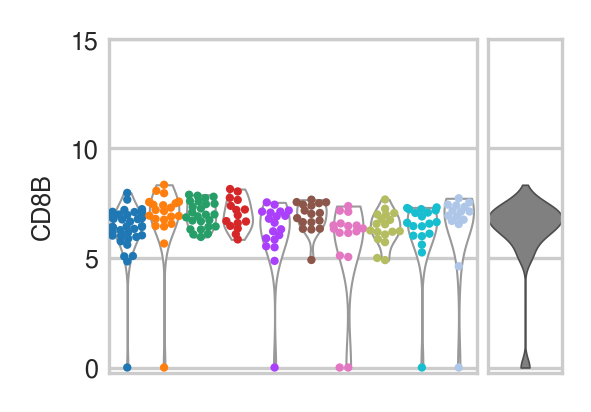

/Users/martinweissman/opt/miniconda3/envs/clonalomics/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 18.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/martinweissman/opt/miniconda3/envs/clonalomics/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 21.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/martinweissman/opt/miniconda3/envs/clonalomics/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 13.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/martinweissman/opt/miniconda3/envs/clonalomics/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 10.5% of the points cannot be placed; you may want to decrease the size of the markers 

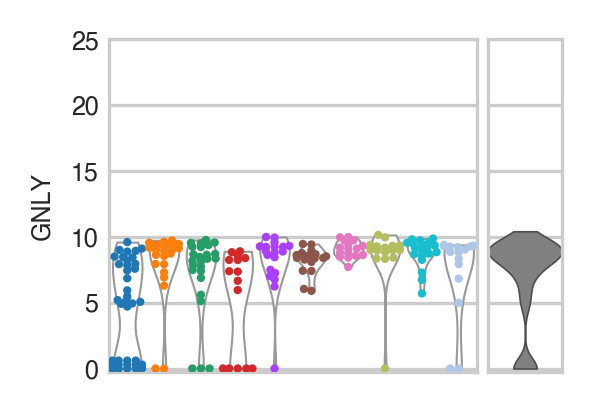

/Users/martinweissman/opt/miniconda3/envs/clonalomics/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 33.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/martinweissman/opt/miniconda3/envs/clonalomics/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 10.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/martinweissman/opt/miniconda3/envs/clonalomics/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 17.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/martinweissman/opt/miniconda3/envs/clonalomics/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 25.9% of the points cannot be placed; you may want to decrease the size of the markers 

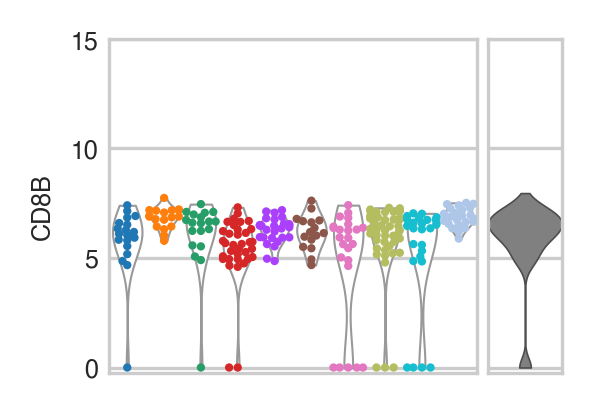

/Users/martinweissman/opt/miniconda3/envs/clonalomics/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 63.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/martinweissman/opt/miniconda3/envs/clonalomics/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 27.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/martinweissman/opt/miniconda3/envs/clonalomics/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 31.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/martinweissman/opt/miniconda3/envs/clonalomics/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 54.3% of the points cannot be placed; you may want to decrease the size of the markers 

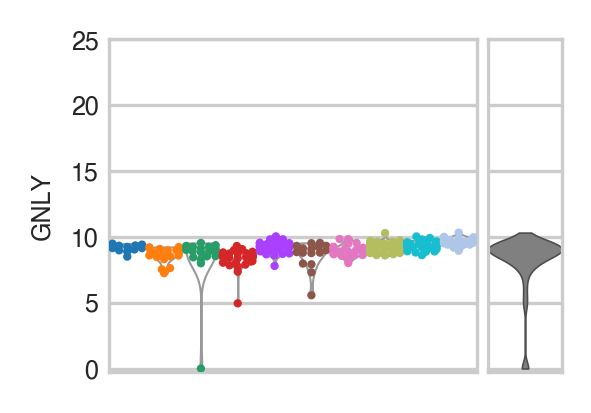

/Users/martinweissman/opt/miniconda3/envs/clonalomics/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 24.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/martinweissman/opt/miniconda3/envs/clonalomics/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 14.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/martinweissman/opt/miniconda3/envs/clonalomics/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 7.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/martinweissman/opt/miniconda3/envs/clonalomics/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 20.8% of the points cannot be placed; you may want to decrease the size of the markers o

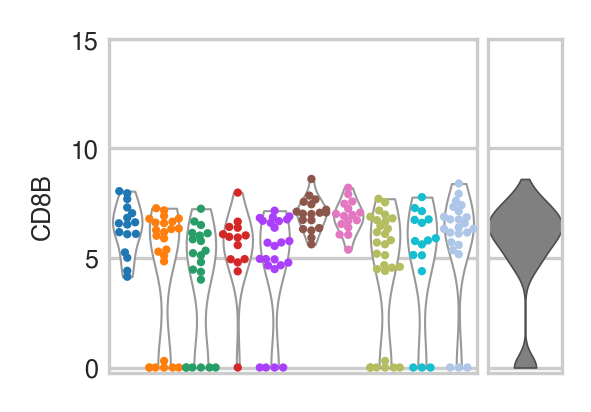

/Users/martinweissman/opt/miniconda3/envs/clonalomics/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 18.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/martinweissman/opt/miniconda3/envs/clonalomics/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 16.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/martinweissman/opt/miniconda3/envs/clonalomics/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 19.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/martinweissman/opt/miniconda3/envs/clonalomics/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 14.3% of the points cannot be placed; you may want to decrease the size of the markers 

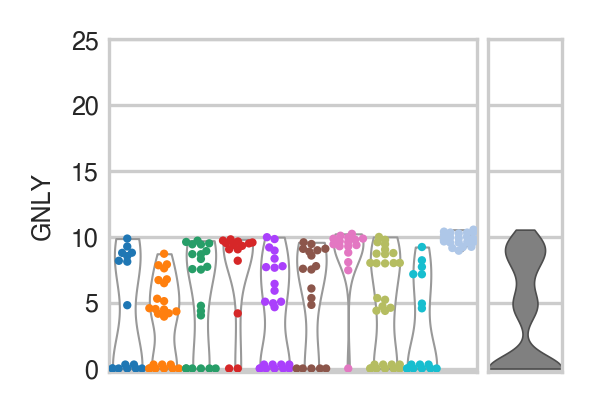

In [77]:
for ds in [a6,a30,jh]:
    for gene in ['CD8B', 'GNLY']:
        if gene == 'CD8B':
            gmax = 15
        else:
            gmax = 25
        minivio(gene, gf=ads[ds].to_df(), full_gf = adata[ds].to_df(), mf=ads[ds].obs, style='tune', gmax=gmax,
                hide_clones=True, show_ons = False, filename='Panels/Violins/{}_{}.pdf'.format(ds,gene))

In [78]:
for ds,gene in [(a6,'GZMK'), (a6,'C1orf228'),
               (a30,'IL7R'), (a30,'ALOX5AP'),
               (jh,'GNLY'), (jh,'CD8B')]:
    minivio(gene, gf=ads[ds].to_df(), mf=ads[ds].obs, style='tune', 
                hide_clones=True, show_ons = False, filename='Panels/Violins/{}_{}.pdf'.format(ds,gene))

TypeError: minivio() missing 1 required positional argument: 'full_gf'

# Little GNLY and celltype plot

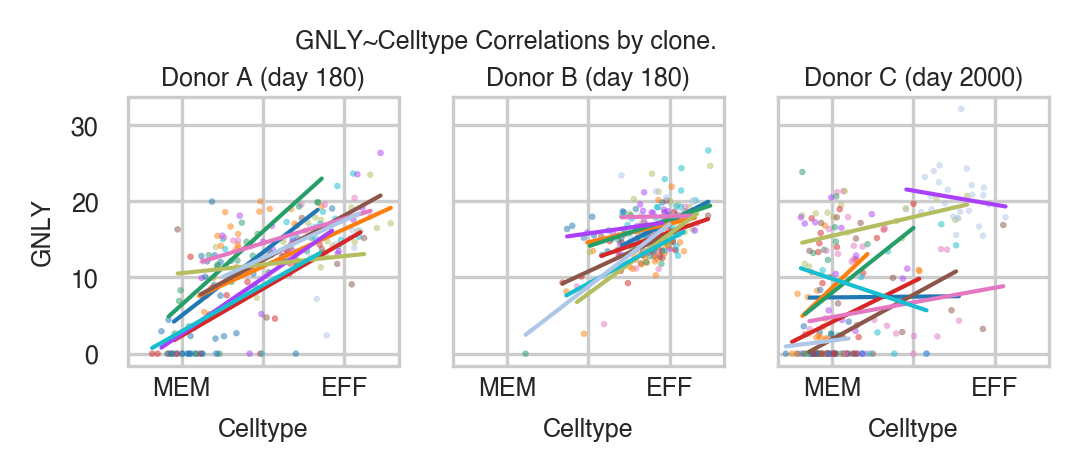

In [93]:
fig,ax = plt.subplots(1,3,figsize=(100*mm, 30*mm), dpi=300, sharey=True)
for j,ds in enumerate(datasets[:3]):
    plot_df = pd.DataFrame(ads[ds].to_df()['GNLY'])
    plot_df['Clone'] = ads[ds].obs.clone_id
    plot_df['Celltype'] = ads[ds].obs.Celltype
    sns.scatterplot(x='Celltype', y='GNLY', hue='Clone', s=2, alpha=0.5,
                    edgecolor=None, data=plot_df, ax=ax[j], legend=False)
    for clone in plot_df.Clone.unique():
        sns.regplot(x='Celltype', y='GNLY', scatter=False, ci=None, line_kws={'linewidth':1.0}, 
                    data=plot_df[plot_df.Clone == clone], ax=ax[j])
    ax[j].set_title(ds_titles[ds], y=0.95)
    ax[j].set_xlim(-0.5,0.5)
    ax[j].set_xticks([-0.3,0,0.3])
    ax[j].set_xticklabels(['MEM','','EFF'])
    ax[j].tick_params(axis='x', pad=-1)
plt.suptitle('GNLY~Celltype Correlations by clone.', y=1.1)

plt.show()

# Regression experiment

Here we look, gene by gene, at how much celltype explains variance.  Then we regress out celltype, and look at how much clonality explains variance.  First is an all-purpose ANOVA function.

Now we compute stuff... it will take a little while.

In [94]:
def quick_eta(gf, grouper):
    N = len(gf)
    groups = grouper.loc[gf.index].unique()
    K = len(groups)
    F_stats = f_oneway(*[gf[grouper == k] for k in groups])[0]
    # p_stats = f_oneway(*[gf[grouper == k] for k in groups])[1]
    F_times_df = F_stats * (K - 1)
    eta_sq = F_times_df / (F_times_df + (N-K))
    return pd.Series(eta_sq, index=gf.columns)
    

In [95]:
reg_df = {}
ad_reg = {}
for ds in datasets:
    X = ads[ds].to_df()
    y = ads[ds].obs.Celltype
    reg_df[ds] = pd.DataFrame(index = X.columns, columns=['rvalue'])
    print('Carrying out regression on {}...'.format(ds_titles[ds]))
    for gene in X.columns:
        LR = ss.linregress(y, X[gene])
        reg_df[ds].loc[gene,'rvalue'] = LR.rvalue
    reg_df[ds]['rsq'] = reg_df[ds]['rvalue']**2
    print('Regressing out celltype scores...')
    ad_reg[ds] = sc.pp.regress_out(ads[ds], 'Celltype', copy=True)

Carrying out regression on Donor A (day 180)...
Regressing out celltype scores...


... storing 'Donor' as categorical
... storing 'DonorDay' as categorical
... storing 'batch' as categorical
... storing 'phase' as categorical


Carrying out regression on Donor B (day 180)...


... storing 'Donor' as categorical
... storing 'DonorDay' as categorical
... storing 'batch' as categorical
... storing 'phase' as categorical


Regressing out celltype scores...
Carrying out regression on Donor C (day 2000)...
Regressing out celltype scores...


... storing 'Donor' as categorical
... storing 'DonorDay' as categorical
... storing 'batch' as categorical
... storing 'phase' as categorical


In [96]:
ETA_df = {}
for ds in datasets:
    X = ad_reg[ds].to_df()
    ETA_df[ds] = pd.DataFrame(index = X.columns)
    for col in ['clone_id'] + ['Shuffle_{}'.format(str(j)) for j in range(100)]:
        y = ad_reg[ds].obs[col]
        ETA_df[ds][col] = quick_eta(X,y)
    print('{} complete.'.format(ds_titles[ds]))
    hrule()

Donor A (day 180) complete.
Donor B (day 180) complete.
Donor C (day 2000) complete.


In [97]:
eta_cut = {}
for ds in datasets:
    eta_cut[ds] = ETA_df[ds].drop('clone_id',axis=1).quantile(1 - 1/len(ETA_df[ds])).median()
    eta_cut[ds] = np.round(eta_cut[ds], 2)
    print(ds, eta_cut[ds])

A1_06_D180 0.16
A1_30_D180 0.13
JH_D2000 0.16
EFF 0.14
MEM 0.2


In [129]:
plot_df = {}
for ds in datasets:
    plot_df[ds] = pd.DataFrame(index=ETA_df[ds].index)
    plot_df[ds]['Clonal impact on variance'] = ETA_df[ds]['clone_id']
    plot_df[ds]['Celltype impact on variance'] = reg_df[ds]['rsq']
    plot_df[ds]['Is clonal'] = pd.Series(plot_df[ds].index, index = plot_df[ds].index).isin(sig_genes[ds])
plot_df[ds]

Clonal impact on variance Celltype impact on variance  Is clonal
gene_name                                                                     
WASH7P                         0.037028                    0.000001      False
MTND1P23                       0.053315                    0.000526      False
MTND2P28                       0.056724                    0.003206      False
hsa-mir-6723                   0.033673                    0.000272      False
RP5-857K21.7                   0.037512                    0.005825      False
...                                 ...                         ...        ...
F8A2-1                         0.112345                    0.006285      False
TMLHE-1                        0.053652                    0.005666      False
VAMP7                          0.050116                    0.000003      False
RNA5-8SP6                      0.019725                    0.000097      False
PSMA6P1                        0.030396                    0.000658      False

[8015 rows x 3 columns]

In [130]:
from adjustText import adjust_text

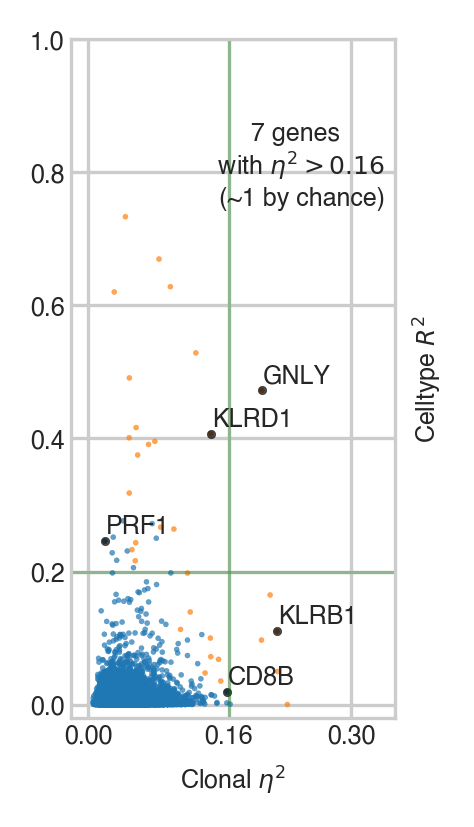

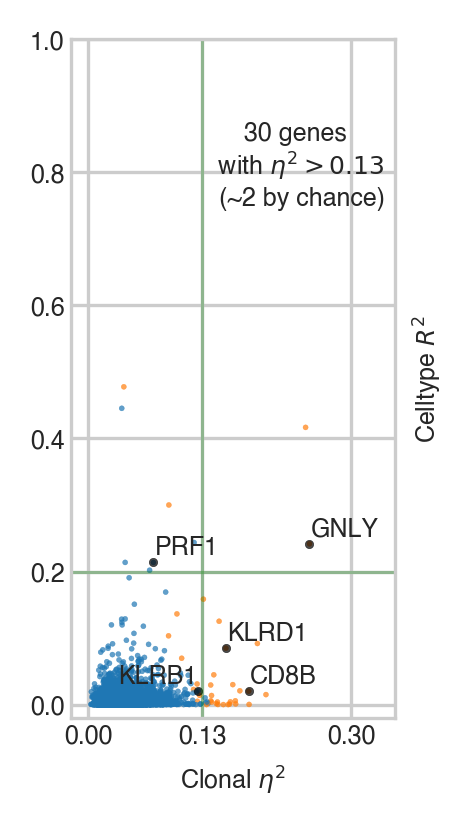

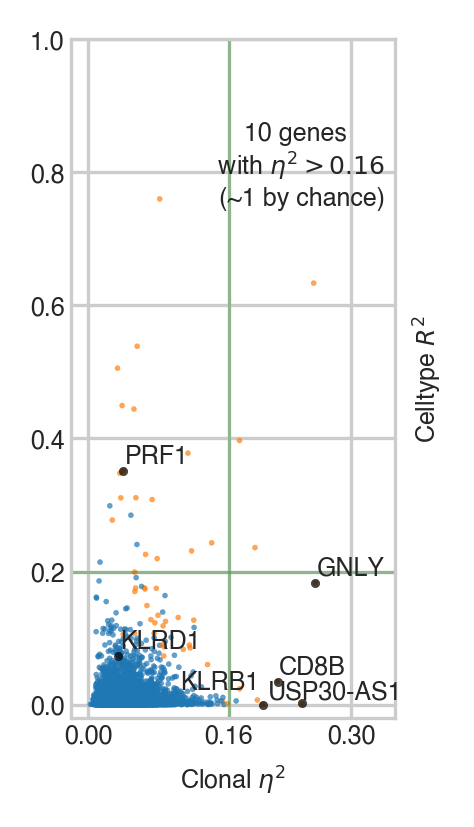

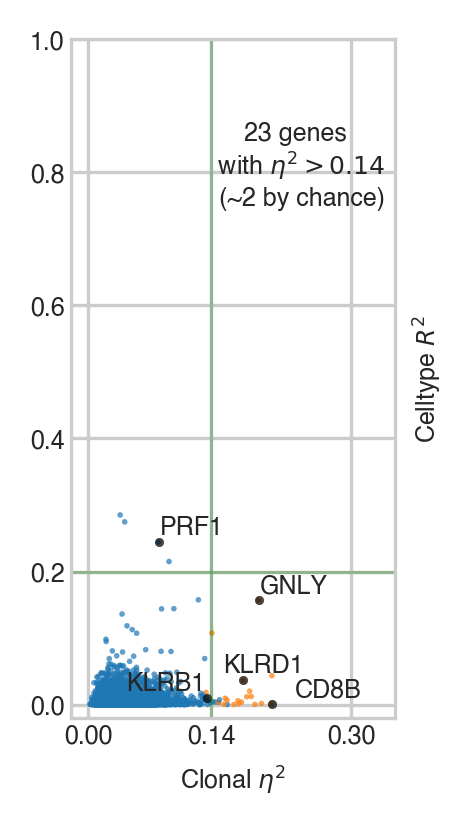

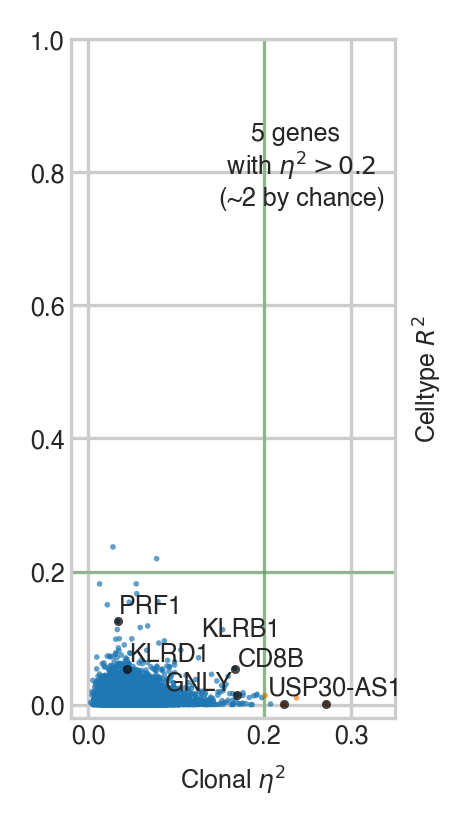

In [131]:
genes_focus = ['CD8B','GNLY','KLRD1','KLRB1','PRF1','USP30-AS1']
        
for ds in datasets:
    sns.set_style('whitegrid')
    setfontsize()
    
    figsize=(40*mm,70*mm)
    fig,ax = plt.subplots(figsize=figsize, dpi=300)
    
    ax.tick_params(axis='both', which='major', pad=-2)

    sns.scatterplot(y='Celltype impact on variance', x = 'Clonal impact on variance', hue='Is clonal',
                    data=plot_df[ds], edgecolor=None, s=1.5, alpha=0.7, legend=False)
    plt.xlim(-0.02,0.35)
    plt.ylim(-0.02,1.0)
    
    ax.set_yticks([0,0.2,0.4,0.6,0.8,1.0])
    ax.set_xticks([0,eta_cut[ds],0.3])

    y_series = plot_df[ds]['Celltype impact on variance']
    x_series = plot_df[ds]['Clonal impact on variance']

    genes_plot = [gene for gene in genes_focus if gene in plot_df[ds].index]
    
    texts = [plt.text(x_series[gene], y_series[gene], gene, ha='center', va='center') for gene in genes_plot]

    adjust_text(texts, expand_text=(1.02, 1.00))
    
    sns.scatterplot(y='Celltype impact on variance', x = 'Clonal impact on variance',  
                    data=plot_df[ds].loc[genes_plot], edgecolor='k', s=4.0, alpha=0.7, color='k')

    ax.axvline(eta_cut[ds], color='green', linewidth=0.75, alpha=0.3)
    ax.axhline(0.2, color='green', linewidth=0.75, alpha=0.3)
    
    by_chance = (ETA_df[ds].drop('clone_id', axis=1) > eta_cut[ds]).sum().median()
    clonal_signal = (ETA_df[ds]['clone_id'] > eta_cut[ds]).sum()
    
    ax.text(0.24, 0.75,
            '{} genes \n with $\eta^2 > {}$ \n (~{} by chance)'.format(clonal_signal, eta_cut[ds], int(by_chance)),
           ha = 'center')
    ax.set_ylabel('Celltype $R^2$')
    ax.yaxis.set_label_position("right")
    ax.set_xlabel('Clonal $\eta^2$')
    #plt.suptitle('Clonal and celltype contributions to variance', y=0.97)
    set_size(fig, figsize)
    plt.savefig('Clonal_Celltype_Gene_Variances/{}_CC_Variance.pdf'.format(ds), bbox_inches='tight')
    
    plt.show()


In [114]:
eta_genes = {}
for ds in datasets:
    eta_sq = ETA_df[ds]['clone_id']
    eta_genes[ds] = eta_sq[eta_sq > eta_cut[ds]].copy().sort_values(ascending=False)
    eta_genes[ds].name = 'Clonal_eta_squared'
    display(eta_genes)
    eta_genes[ds].to_csv('eta_genes_'+ds+'.csv')
    

{'A1_06_D180': gene_name
 PAX8-AS1       0.227043
 C1orf228       0.215879
 KLRB1          0.215296
 CD300A         0.207356
 GNLY           0.197850
 KCNN4          0.197497
 KLRC4-KLRK1    0.161691
 Name: Clonal_eta_squared, dtype: float64}

{'A1_06_D180': gene_name
 PAX8-AS1       0.227043
 C1orf228       0.215879
 KLRB1          0.215296
 CD300A         0.207356
 GNLY           0.197850
 KCNN4          0.197497
 KLRC4-KLRK1    0.161691
 Name: Clonal_eta_squared, dtype: float64,
 'A1_30_D180': gene_name
 GNLY            0.252283
 GZMH            0.247824
 AMICA1          0.202601
 ZNF683          0.192834
 GFPT2           0.183348
 CD8B            0.182904
 ITGB1           0.172805
 ITM2A           0.168032
 NCAPG2          0.167677
 HLA-DRB1        0.164737
 CD5             0.161937
 NSG1            0.161096
 MT-ND5          0.159485
 KLRD1           0.156918
 CACNA2D4        0.153996
 IL7R            0.149127
 C1orf162        0.147763
 HAVCR2          0.147235
 DDX10           0.145934
 DFNB31          0.143074
 TTPAL           0.140517
 HOPX            0.140403
 ALOX5AP         0.139660
 RP11-23P13.6    0.139541
 CD160           0.136826
 SLC35B4         0.135271
 KLRG1           0.134774
 GRK5            0.133742
 MAT

{'A1_06_D180': gene_name
 PAX8-AS1       0.227043
 C1orf228       0.215879
 KLRB1          0.215296
 CD300A         0.207356
 GNLY           0.197850
 KCNN4          0.197497
 KLRC4-KLRK1    0.161691
 Name: Clonal_eta_squared, dtype: float64,
 'A1_30_D180': gene_name
 GNLY            0.252283
 GZMH            0.247824
 AMICA1          0.202601
 ZNF683          0.192834
 GFPT2           0.183348
 CD8B            0.182904
 ITGB1           0.172805
 ITM2A           0.168032
 NCAPG2          0.167677
 HLA-DRB1        0.164737
 CD5             0.161937
 NSG1            0.161096
 MT-ND5          0.159485
 KLRD1           0.156918
 CACNA2D4        0.153996
 IL7R            0.149127
 C1orf162        0.147763
 HAVCR2          0.147235
 DDX10           0.145934
 DFNB31          0.143074
 TTPAL           0.140517
 HOPX            0.140403
 ALOX5AP         0.139660
 RP11-23P13.6    0.139541
 CD160           0.136826
 SLC35B4         0.135271
 KLRG1           0.134774
 GRK5            0.133742
 MAT

{'A1_06_D180': gene_name
 PAX8-AS1       0.227043
 C1orf228       0.215879
 KLRB1          0.215296
 CD300A         0.207356
 GNLY           0.197850
 KCNN4          0.197497
 KLRC4-KLRK1    0.161691
 Name: Clonal_eta_squared, dtype: float64,
 'A1_30_D180': gene_name
 GNLY            0.252283
 GZMH            0.247824
 AMICA1          0.202601
 ZNF683          0.192834
 GFPT2           0.183348
 CD8B            0.182904
 ITGB1           0.172805
 ITM2A           0.168032
 NCAPG2          0.167677
 HLA-DRB1        0.164737
 CD5             0.161937
 NSG1            0.161096
 MT-ND5          0.159485
 KLRD1           0.156918
 CACNA2D4        0.153996
 IL7R            0.149127
 C1orf162        0.147763
 HAVCR2          0.147235
 DDX10           0.145934
 DFNB31          0.143074
 TTPAL           0.140517
 HOPX            0.140403
 ALOX5AP         0.139660
 RP11-23P13.6    0.139541
 CD160           0.136826
 SLC35B4         0.135271
 KLRG1           0.134774
 GRK5            0.133742
 MAT

{'A1_06_D180': gene_name
 PAX8-AS1       0.227043
 C1orf228       0.215879
 KLRB1          0.215296
 CD300A         0.207356
 GNLY           0.197850
 KCNN4          0.197497
 KLRC4-KLRK1    0.161691
 Name: Clonal_eta_squared, dtype: float64,
 'A1_30_D180': gene_name
 GNLY            0.252283
 GZMH            0.247824
 AMICA1          0.202601
 ZNF683          0.192834
 GFPT2           0.183348
 CD8B            0.182904
 ITGB1           0.172805
 ITM2A           0.168032
 NCAPG2          0.167677
 HLA-DRB1        0.164737
 CD5             0.161937
 NSG1            0.161096
 MT-ND5          0.159485
 KLRD1           0.156918
 CACNA2D4        0.153996
 IL7R            0.149127
 C1orf162        0.147763
 HAVCR2          0.147235
 DDX10           0.145934
 DFNB31          0.143074
 TTPAL           0.140517
 HOPX            0.140403
 ALOX5AP         0.139660
 RP11-23P13.6    0.139541
 CD160           0.136826
 SLC35B4         0.135271
 KLRG1           0.134774
 GRK5            0.133742
 MAT

In [119]:
for ds in datasets:
    print(sig_genes[ds])
    hrule(length=10)
    print(eta_genes[ds].index)
    print([gene for gene in eta_genes[ds].index if gene not in sig_genes[ds]])
    hrule()

['AOAH', 'C1orf228', 'CCL4', 'CCR7', 'CD300A', 'COL18A1', 'CST7', 'FCGR3A', 'FCRL6', 'FGFBP2', 'FOS', 'GNLY', 'GPR56', 'GZMB', 'GZMH', 'GZMK', 'IFNG-AS1', 'IL7R', 'ITGAM', 'KCNN4', 'KLRB1', 'KLRD1', 'LDHB', 'LTB', 'NKG7', 'NOSIP', 'PAX8-AS1', 'RHOH', 'RP11-23P13.6', 'S1PR5', 'SELL', 'TCF7']
Index(['PAX8-AS1', 'C1orf228', 'KLRB1', 'CD300A', 'GNLY', 'KCNN4',
       'KLRC4-KLRK1'],
      dtype='object', name='gene_name')
['KLRC4-KLRK1']
['ALOX5AP', 'AMICA1', 'C1orf162', 'CACNA2D4', 'CD28', 'CD300A', 'CD5', 'CD8B', 'DDX10', 'DFNB31', 'FCGR3A', 'GFPT2', 'GNLY', 'GPR56', 'GZMH', 'HAVCR2', 'HLA-DRB1', 'HLA-DRB5', 'HOPX', 'IL7R', 'ITGB1', 'ITM2A', 'KLRD1', 'KLRG1', 'MT-ND5', 'NCAPG2', 'NKG7', 'NSG1', 'RNVU1-19', 'RP11-23P13.6', 'SATB1', 'SPON2', 'TSPYL2-1', 'TTPAL', 'ZNF683']
Index(['GNLY', 'GZMH', 'AMICA1', 'ZNF683', 'GFPT2', 'CD8B', 'ITGB1', 'ITM2A',
       'NCAPG2', 'HLA-DRB1', 'CD5', 'NSG1', 'MT-ND5', 'KLRD1', 'CACNA2D4',
       'IL7R', 'C1orf162', 'HAVCR2', 'DDX10', 'DFNB31', 'TTPAL', 'HO

# Matched celltype fake clones

In [290]:
adata[jh]

AnnData object with n_obs × n_vars = 1201 × 8015
    obs: 'Celltype', 'Donor', 'DonorDay', 'G2M_score', 'S_score', 'Timepoint', 'batch', 'clone_id', 'is_clone0', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'log1p_total_counts_mt', 'n_counts', 'n_genes', 'n_genes_by_counts', 'obs_names', 'pct_counts_mt', 'phase', 'total_counts', 'total_counts_mt'
    var: 'Celltype_load', 'GC_content', 'gene_name', 'highly_variable', 'highly_variable_rank', 'log1p_mean_counts', 'log1p_total_counts', 'mean_counts', 'means', 'mt', 'n_cells', 'n_cells_by_counts', 'n_counts', 'pct_dropout_by_counts', 'total_counts', 'transcript_length', 'variances', 'variances_norm'

In [301]:
np.random.choice([-2,5,7])

7

In [291]:
bigclones[jh]

['C35', 'C107', 'C154', 'C27', 'C87', 'C75', 'C29', 'C67', 'C25', 'C38']

In [334]:
def make_matched_clone(ad, clone):
    ct_series = ad.obs.Celltype.sort_values()
    ct_order = pd.Series(range(len(ct_series)), index=ct_series.index)
    cl_cells = list(ad[ad.obs.clone_id == clone, :].obs_names)
    newcells = cl_cells[:] # Make copy.
    print(len(cl_cells), len(newcells))
    for j,cell in enumerate(cl_cells):
        #print(cell, ct_order[cell], ct_series[cell])
        newcell_num = ct_order[cell] + 1 #np.random.choice([-1,1])
        newcells[j] = ct_series.index[newcell_num]
    #display(ct_series.loc[cl_cells])
    #display(ct_series.loc[newcells])
    return newcells

In [335]:
adata[jh].obs['FakeClone'] = ''
for cl in bigclones[jh]:
    new_clone = make_matched_clone(adata[jh], cl)
    #print(len(new_clone))
    adata[jh].obs.loc[new_clone,'FakeClone'] = cl+'_fake'

30 30
26 26
26 26
26 26
21 21
18 18
17 17
16 16
16 16
14 14


In [336]:
adata[jh].obs['FakeClone'].value_counts()

             991
C35_fake      30
C27_fake      26
C154_fake     26
C107_fake     26
C87_fake      21
C75_fake      18
C29_fake      17
C67_fake      16
C25_fake      16
C38_fake      14
Name: FakeClone, dtype: int64

In [337]:
ad_fake = adata[jh][adata[jh].obs['FakeClone'] != '', :]
ad_fake

View of AnnData object with n_obs × n_vars = 210 × 8015
    obs: 'Celltype', 'Donor', 'DonorDay', 'G2M_score', 'S_score', 'Timepoint', 'batch', 'clone_id', 'is_clone0', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'log1p_total_counts_mt', 'n_counts', 'n_genes', 'n_genes_by_counts', 'obs_names', 'pct_counts_mt', 'phase', 'total_counts', 'total_counts_mt', 'FakeClone'
    var: 'Celltype_load', 'GC_content', 'gene_name', 'highly_variable', 'highly_variable_rank', 'log1p_mean_counts', 'log1p_total_counts', 'mean_counts', 'means', 'mt', 'n_cells', 'n_cells_by_counts', 'n_counts', 'pct_dropout_by_counts', 'total_counts', 'transcript_length', 'variances', 'variances_norm'

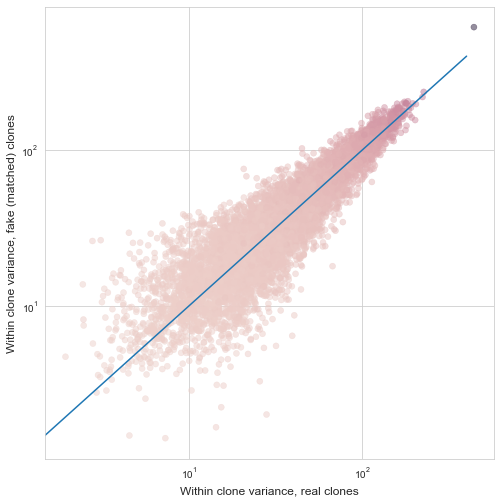

In [357]:
plot_df = pd.DataFrame(index=ads[jh].to_df().columns)
plot_df['Real'] = ads[jh].to_df().groupby(ads[jh].obs.clone_id).var().sum()
plot_df['Fake'] = ad_fake.to_df().groupby(ad_fake.obs.FakeClone).var().sum()
plot_df['Var'] = adata[jh].to_df().var()
desetfontsize()
fig,ax = plt.subplots(1,1,figsize=(8,8))

sns.scatterplot(x='Real', y='Fake', hue='Var', data=plot_df, legend=False, edgecolor=None, alpha=0.5)
ax.set_xlabel('Within clone variance, real clones')
ax.set_ylabel('Within clone variance, fake (matched) clones')
plt.plot([0,400], [0,400])
plt.xscale('log')
plt.yscale('log')
plt.show()

In [354]:
(plot_df['Real'] < plot_df['Fake']).sum()

4369

In [356]:
p_sig[jh]

gene_name
GZMB           1.177240e-37
FCGR3A         1.557921e-28
GZMH           6.275643e-27
TIGIT          5.050347e-24
ZNF683         1.712470e-20
GNLY           4.397361e-19
FCGR3B         1.236872e-17
NKG7           3.058785e-11
GZMK           1.265223e-10
PRF1           1.737040e-10
FGR            3.006519e-10
F2R            3.201310e-10
IL7R           5.932640e-10
ITGAL          6.078623e-10
LTB            1.554091e-09
USP30-AS1      3.778885e-09
CD63           9.834051e-09
FGFBP2         1.393249e-08
BZRAP1         1.568995e-08
GPR56          2.997881e-08
CD8B           3.818393e-08
FCRL6          4.721004e-08
AOAH           4.897383e-08
FAM211A-AS1    5.548059e-08
DGKA           8.060724e-08
COL6A2         8.574948e-08
IL2RB          1.520536e-07
CTSW           1.884879e-07
RPLP0          3.338962e-07
RPLP0P6        5.690024e-07
TMSB4XP8       6.984875e-07
STOM           7.259477e-07
KLRB1          8.749445e-07
PRSS21         1.045578e-06
FCRL3          1.056023e-06
ANXA2     

gene_name
WASH7P          79.370796
MTND1P23        22.666023
MTND2P28        65.243332
hsa-mir-6723    52.728287
RP5-857K21.7    25.966845
                  ...    
F8A2-1          16.560982
TMLHE-1         32.585720
VAMP7           44.468815
RNA5-8SP6       45.735569
PSMA6P1          9.476218
Length: 8015, dtype: float32

# Little clonal clustering experiment

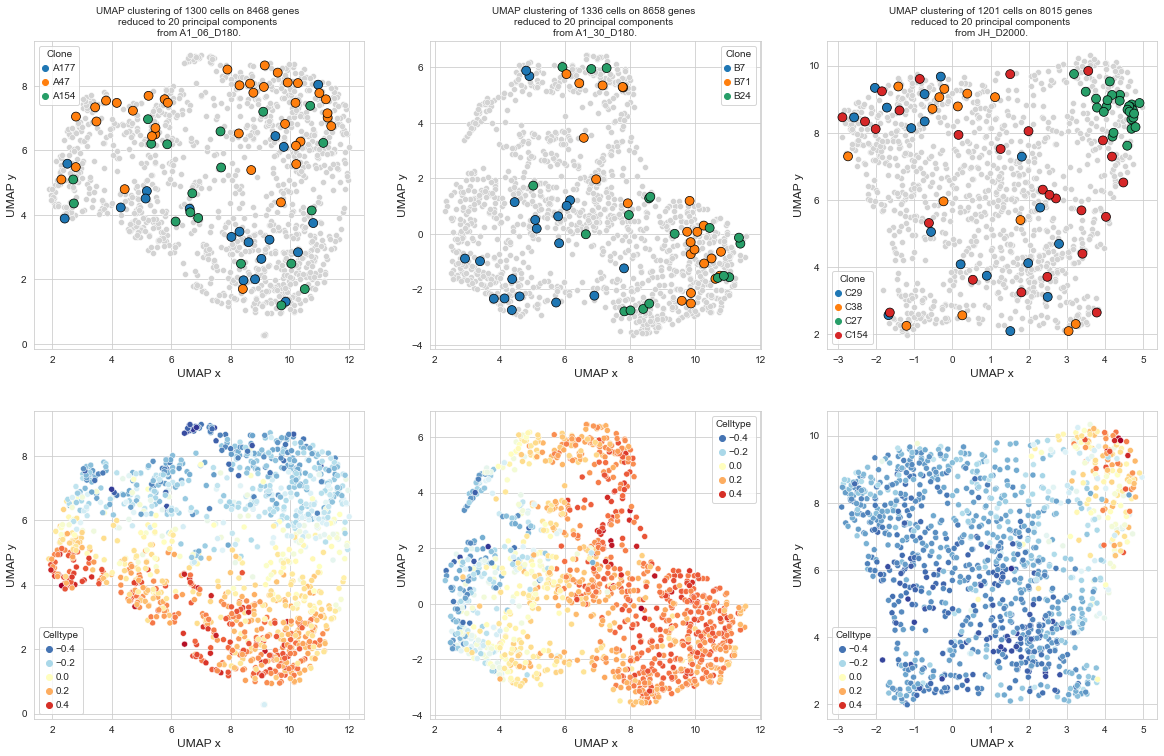

In [813]:
n_components = 20
n_neighbors = 10
min_dist = 0.25
fig, ax = plt.subplots(2,3, figsize=(20,12))
desetfontsize()

for j,ds in enumerate(datasets):
    X = adata[ds].to_df()
    y = adata[ds].obs.clone_id
    z = adata[ds].obs.Celltype
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X) # Apply PCA with 20 components.
    X_embedded = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, 
                           random_state = 42, metric='cosine').fit_transform(X_pca) # Reduce from 10 components to 2-dimensions.

    cl_df = pd.DataFrame(X_embedded, columns = ['UMAP x', 'UMAP y'], index=X.index) # Just for graphing.
    cl_df['Clone'] = y.values
    cl_df['Celltype'] = z.values
    cl_df['Clone'] = cl_df['Clone'].map({'C29':'C29', 'C27':'C27', 'C154':'C154', 'C38':'C38',
                                        'A47':'A47', 'A177':'A177', 'A154':'A154',
                                         'B71':'B71', 'B7':'B7','B24':'B24'}).fillna('Other')
    g = sns.scatterplot(x='UMAP x', y='UMAP y', data = cl_df[cl_df['Clone'] == 'Other'], color='lightgray',
                        ax=ax[0,j])
    g = sns.scatterplot(x='UMAP x', y='UMAP y', hue='Clone', data = cl_df[cl_df['Clone'] != 'Other'], 
                        edgecolor='k', ax=ax[0,j], s=80)
    g = sns.scatterplot(x='UMAP x', y='UMAP y', hue='Celltype', palette='RdYlBu_r', hue_norm=(-0.5,0.5), 
                        data = cl_df, ax=ax[1,j])
    
    #if j == 0:
    #    g.legend(loc='center left', bbox_to_anchor=(-0.55, 0.5), ncol=1)

    ax[0,j].set_title('UMAP clustering of {} cells on {} genes \n' 
                    'reduced to {} principal components \n'
                    'from {}.'.format(X.shape[0], X.shape[1], n_components, ds))

plt.show()

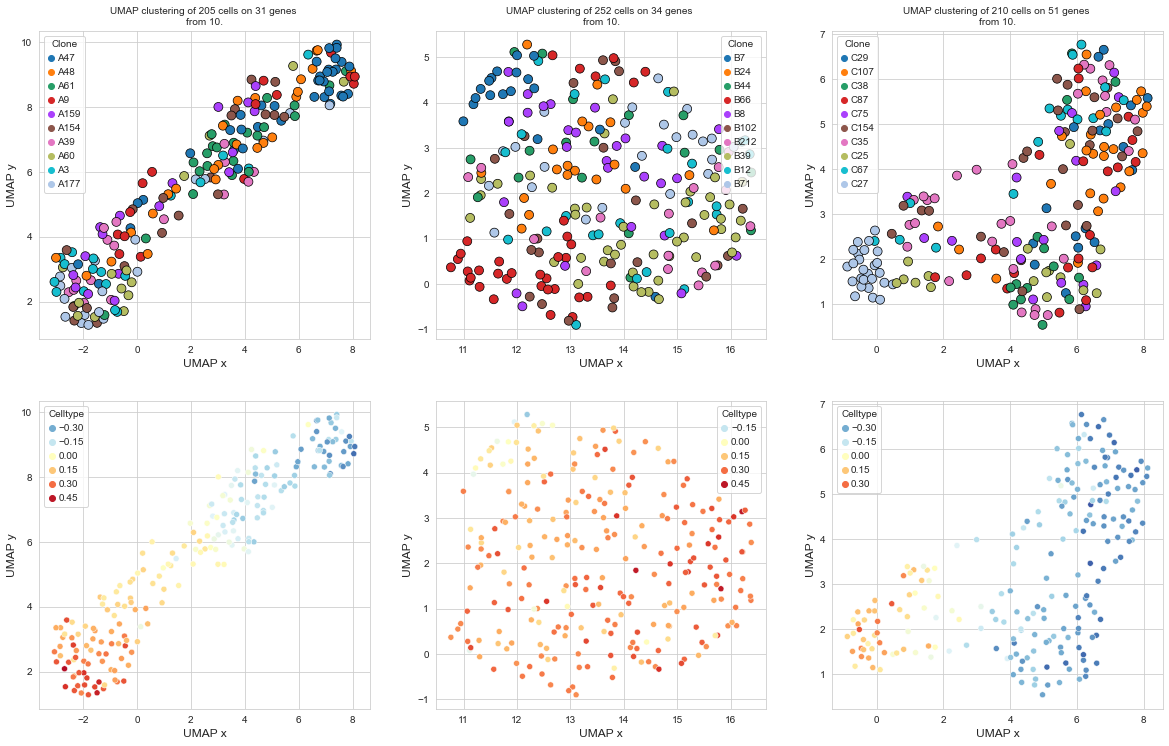

In [819]:
n_components = 10
n_neighbors = 10
min_dist = 0.25
fig, ax = plt.subplots(2,3, figsize=(20,12))
desetfontsize()

for j,ds in enumerate(datasets):
    X = ads[ds].to_df()
    X = X[sig_genes[ds]]
    y = ads[ds].obs.clone_id
    z = ads[ds].obs.Celltype
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X) # Apply PCA with 20 components.
    X_embedded = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, 
                           random_state = 42, metric='cosine').fit_transform(X) # Reduce from 10 components to 2-dimensions.

    cl_df = pd.DataFrame(X_embedded, columns = ['UMAP x', 'UMAP y'], index=X.index) # Just for graphing.
    cl_df['Clone'] = y.values
    cl_df['Celltype'] = z.values
    #cl_df['Clone'] = cl_df['Clone'].map({'C29':'C29', 'C27':'C27', 'C154':'C154', 'C38':'C38',
    #                                    'A47':'A47', 'A177':'A177', 'A154':'A154',
    #                                     'B71':'B71', 'B7':'B7','B24':'B24'}).fillna('Other')
    #g = sns.scatterplot(x='UMAP x', y='UMAP y', data = cl_df[cl_df['Clone'] == 'Other'], color='lightgray',
    #                    ax=ax[0,j])
    g = sns.scatterplot(x='UMAP x', y='UMAP y', hue='Clone', data = cl_df[cl_df['Clone'] != 'Other'], 
                        edgecolor='k', ax=ax[0,j], s=80)
    g = sns.scatterplot(x='UMAP x', y='UMAP y', hue='Celltype', palette='RdYlBu_r', hue_norm=(-0.5,0.5), 
                        data = cl_df, ax=ax[1,j])
    
    #if j == 0:
    #    g.legend(loc='center left', bbox_to_anchor=(-0.55, 0.5), ncol=1)

    ax[0,j].set_title('UMAP clustering of {} cells on {} genes \n' 
                    'from {}.'.format(X.shape[0], X.shape[1], n_components, ds))

plt.show()

# SVM Quickshot

In [436]:
def CV_map(gs, swap=False, savefig=False):  # parameter_grid and grid_search.
    '''
    A general-purpose visualization for grid-search cross-validations.
    Displays predictive accuracy as a heatmap, based on different
    choices of parameters.  Displays optimal parameters in title.
    
    Args:
        gs (sklearn.model_selection.GridSearchCV):  The grid-search object.
        swap:  Set to True to switch the axes.
        
    Returns:
        None
        
    '''
    results = gs.cv_results_
    means = results['mean_test_score']
    params = list(gs.param_grid.keys())
    
    ser = pd.Series(list(means),
                  index=pd.MultiIndex.from_tuples(
                      [tuple(d.values()) for d in results['params']])
               )
    gs_df = ser.unstack().fillna(0)
    gs_df.shape 
    if swap:
        gs_df = gs_df.transpose()
        params = params[::-1] # Switch the order of the parameter list.
    
    f, ax = plt.subplots(figsize=(12,12))
    sns.heatmap(gs_df, annot=True, square=True, fmt="2.0%", linewidths=.5, 
                cbar_kws={'fraction':0.025, 'pad':0.05}, ax=ax)
    cbar = ax.collections[0].colorbar
    cbar.set_ticks([.5, .6, .7, .8, .9])
    cbar.set_ticklabels(['50%', '60%', '70%', '80%', '90%'])
    ax.set_xlabel(params[1])
    ax.set_ylabel(params[0])
    plt.yticks(rotation=0)
    bestacc = gs.best_score_
    ax.set_title("Result of grid-search with 5-fold cross-validation. \n"
                 "Best score {0:2.1%} with parameters \n"
                 "{1} ".format(gs.best_score_, gs.best_params_))
    if savefig:
        plt.savefig('CV_map.svg')

In [437]:
def confusion_matrix(X,y,pipe, reps=2, classlist = None, filename=None):
    if classlist:
        classes = classlist
    else:
        classes = sorted(y.unique())
    counts = pd.DataFrame(0, index=classes, columns=classes)
    cpops = pd.DataFrame(0, index=classes, columns=['pop'])
    correct = 0
    total = 0
    for t in range(reps):
        this_pipe = base.clone(pipe)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        this_pipe.fit(X_train, y_train)
        y_pred = this_pipe.predict(X_test)
        actual = y_test
        predicted = y_pred
        for j in range(len(y_test)):
            total += 1
            if y_test[j] == y_pred[j]:
                correct += 1
            cpops.loc[y_test[j],'pop'] += 1
            counts.loc[y_test[j], y_pred[j]] += 1
    
    valid = counts.apply(lambda column : column/cpops['pop']) #['pop'] )
    valid_dec = (valid*100).astype(int)
    
    #f, ax = plt.subplots(figsize=(8,7))
    f, ax = plt.subplots(figsize=(1.2,1.25), dpi=300)
    setfontsize()
    #fmt="2.0%"
    sns.heatmap(valid, annot=valid_dec, annot_kws={'fontsize':5}, fmt="d", square=True, linewidths=.25, cbar=None,
                cbar_kws={'fraction':0.02, 'pad':0.02}, ax=ax)
    #cbar = ax.collections[0].colorbar
    #cbar.set_ticks([0, .25, .5, .75, 1])
    #cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])
    ax.set_xticks([])
    ax.set_yticks([])
    tickypos = -0.3
    pal = sns.color_palette()
    lut = dict(zip(classes, pal))
    for j,cl in enumerate(classes):
        ax.add_patch(Rectangle((tickypos,j+0.1),0.3,0.8, color=lut[cl],fill=True,clip_on=False))
        ax.add_patch(Rectangle((j+0.1,tickypos),0.8,0.3, color=lut[cl],fill=True,clip_on=False))
        ax.add_patch(Rectangle((len(classes)-tickypos,j+0.1),-0.3,0.8, color=lut[cl],fill=True,clip_on=False))
        ax.add_patch(Rectangle((j+0.1,len(classes)-tickypos),0.8,-0.3, color=lut[cl],fill=True,clip_on=False))
    ax.set_ylabel("Actual clone")
    ax.set_xlabel("Predicted clone")
    ax.set_title("Predicted clonality (%).".format(correct / total))
    
    if filename:
        set_size(f, (1.2, 1.25))
        plt.savefig(filename, bbox_inches='tight')
    # "{} trials, in {} batches with independent splits.".format(correct/total, total, reps))

In [438]:
def sort_by(df, col, valuelist):
    '''
    Sorts a data frame, according to the values in a column,
    and a chosen order for these values.
    '''
    if set(df[col].unique()) != set(valuelist):
        print('Warning, cannot sort!')
        return df
    value_dict = {valuelist[j]:j for j in range(len(valuelist))}
    df['newcol'] = df[col].apply(lambda v : value_dict[v])
    df.sort_values('newcol', inplace=True)
    df.drop('newcol', axis=1)
    return df

In [439]:
def downsample(X,y):
    ymin = y.value_counts().min()
    sample = []
    for cl in y.unique():
        cells_cl = y[y == cl].index
        sample_cl = np.random.choice(cells_cl, ymin, replace=False)
        sample = sample + list(sample_cl)
    return X.loc[sample], y.loc[sample]
        

In [457]:
X = ads[a6].to_df().copy()
y = ads[a6].obs.clone_id.copy()

X,y = downsample(X,y)

In [458]:
y.value_counts()

A47     15
A48     15
A61     15
A9      15
A159    15
A154    15
A39     15
A60     15
A3      15
A177    15
Name: clone_id, dtype: int64

In [459]:
#  DANGER DANGER!  The lines below ignore all warnings.
#  It's nice to avoid all the convergence warnings.  
#  But dangerous in general.
import warnings
warnings.filterwarnings("ignore")
#  End of warning.... proceed below.

SVM_pipe = Pipeline([ ('mm', MinMaxScaler()),
                     ('skb', SelectKBest(score_func = f_classif, k=110)),
                     ('svm', LinearSVC(random_state=0, tol=1e-4, C=1.0, max_iter=2000)) ])

param_grid = dict(skb__k = [2,5,10,25,50,100,150,200,250,300], svm__C = [0.001, 0.01, 0.1, 1.0, 10.0])

grid_search = GridSearchCV(SVM_pipe, param_grid=param_grid, cv=5) #5-fold cross-validation.
grid_search.fit(X,y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('mm', MinMaxScaler()),
                                       ('skb', SelectKBest(k=110)),
                                       ('svm',
                                        LinearSVC(max_iter=2000,
                                                  random_state=0))]),
             param_grid={'skb__k': [2, 5, 10, 25, 50, 100, 150, 200, 250, 300],
                         'svm__C': [0.001, 0.01, 0.1, 1.0, 10.0]})

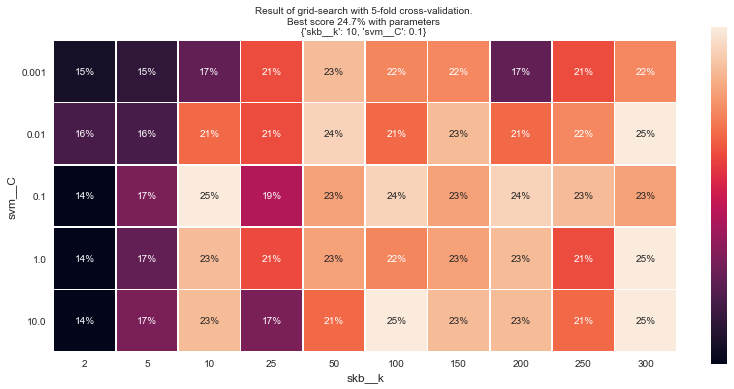

In [460]:
desetfontsize()
CV_map(grid_search, swap=True)

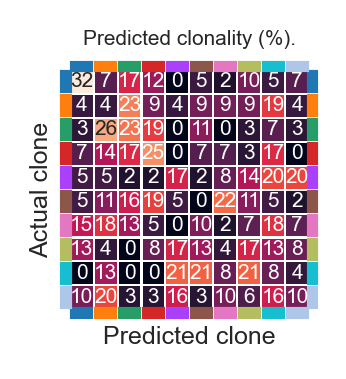

In [461]:
opt_k = grid_search.best_params_['skb__k'] # Use optimal number of genes.
opt_C = grid_search.best_params_['svm__C'] # Use optimal C-parameter for linear SVM.

SVMpipe = make_pipeline(MinMaxScaler(), 
                        SelectKBest(score_func = f_classif, k=opt_k), 
                        LinearSVC(random_state=0, tol=1e-4, max_iter = 2000, C=opt_C))

setfontsize()
classlist = list(clonetype[a6].categories)
confusion_matrix(X,y,SVMpipe, reps=10, classlist = classlist, filename='Panels/Confusion.pdf')